# Llama-2-eus Eustrivia

## Checkpoint Comparison

In [1]:
base_model = {
    "llama-2": "Llama-2-7b-hf"
}
finetuned_model = "finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k/"
checkpoints = list(range(0, 6900, 300))
finetuned_models = {
    finetuned_model: [f"checkpoint-{checkpoint}" for checkpoint in checkpoints]
}
names = ["finetune_llama-2_raw"] * len(checkpoints)
datasets = ["xstory_cloze"]

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

from collections import defaultdict
import os

import json

def read_file(f):
    with open(f, "r") as f:
        return json.load(f)


def get_dataframes_eustrivia(all_results, datasets):
    for dataset in datasets:
        results = pd.DataFrame(all_results[dataset], index=["acc"]).T
        results["dataset"] = dataset
        # adapt names to match length
        results["model"] = names[:len(results["acc"])]
        # remove checkpoints that are not in all_results
        checkpoints_present = [int(checkpoint.split("/")[-1].split("-")[-1]) for checkpoint in all_results[dataset]]
        results["checkpoint"] = checkpoints_present
        yield results
        
def get_results_eustrivia(results):
    res = {k: round(v["acc,none"] * 100, 1) for k, v in results.items()}
    res = dict(sorted(res.items()))
    task_names = list(res.keys())
    results_dataset = defaultdict(dict)
    dataset_names = task_names
    for dataset_name in dataset_names:
        results_dataset[dataset_name] = defaultdict(dict)
    for task in task_names:
        results_dataset[dataset_name] = res[task]
    return results_dataset
        
def get_all_results_eustrivia(base_model, finetuned_models, datasets):
    all_results = defaultdict(dict)
    for model, name in base_model.items():
        for dataset in datasets:
            shots = 5
            # check if file exists
            if not os.path.exists(f"../results/{model}/{name}/{name}_{dataset}_{shots}-shot.json"):
                all_results[dataset][f"{model}/checkpoint-0"] = 1/3*100
                continue
            output = read_file(
                f"../results/{model}/{name}/{name}_{dataset}_{shots}-shot.json"
            )
            results = get_results_eustrivia(output["results"])
            for dataset_name in results:
                if dataset_name not in all_results:
                    all_results[dataset_name] = defaultdict(dict)
                all_results[dataset_name][f"{model}/checkpoint-0"] = results[dataset_name]
    for model, names in finetuned_models.items():
        for dataset in datasets:
            for name in names:
                shots = 5
                # check if file exists
                if not os.path.exists(f"../results/{model}/{name}/{dataset}_{shots}-shot.json"):
                    print(f"../results/{model}/{name}/{dataset}_{shots}-shot.json")
                    continue
                output = read_file(
                    f"../results/{model}/{name}/{dataset}_{shots}-shot.json"
                )
                results = get_results_eustrivia(output["results"])
                for dataset_name in results:
                    if dataset_name not in all_results:
                        all_results[dataset_name] = defaultdict(dict)
                    all_results[dataset_name][f"{model}{name}"] = results[dataset_name]
    return all_results

def plot_checkpoint_df_concat(dfs, checkpoints_present, title):
    df_concat = pd.concat(dfs, ignore_index=True)
    # single plot
    fig, ax = plt.subplots()
    for dataset in datasets:
        df = df_concat[df_concat["dataset"] == dataset]
        ax.plot(df["checkpoint"], df["acc"], marker="o", label=dataset)
    ax.set_title(title)
    ax.set_xticks(checkpoints_present)
    ax.set_xticklabels(checkpoints_present, rotation="vertical")
    ax.legend()

../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k//checkpoint-0/eustrivia_5-shot.json
../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k//checkpoint-600/eustrivia_5-shot.json
../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k//checkpoint-900/eustrivia_5-shot.json
../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k//checkpoint-1200/eustrivia_5-shot.json
../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k//checkpoint-1500/eustrivia_5-shot.json
../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k//checkpoint-2100/eustrivia_5-shot.json
../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k//checkpoint-2700/eustrivia_5-shot.json
../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k//checkpoint-3300/eustrivia_5-shot.json
../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k//checkpoint-0/eustrivia_mt_5-shot.json
../results/finetune_llama-2_raw/7

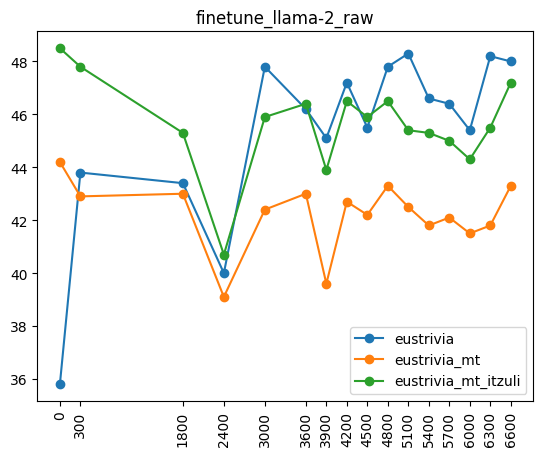

In [3]:
import pandas as pd

datasets = ["eustrivia", "eustrivia_mt", "eustrivia_mt_itzuli"]
all_results_eustrivia = get_all_results_eustrivia(base_model, finetuned_models, datasets)

checkpoints_present = [int(checkpoint.split("/")[-1].split("-")[-1]) for checkpoint in all_results_eustrivia[datasets[0]]]

dfs = list(get_dataframes_eustrivia(all_results_eustrivia, datasets))

plot_checkpoint_df_concat(dfs, checkpoints_present, title="finetune_llama-2_raw")


## Grouped Checkpoint Comparison

In [4]:
def get_dataframe(model, task, checkpoint=6600, size=7):
    if model == "llama-2":
        if size != 70:
            df = pd.read_json(f"../results/{model}/Llama-2-{size}b-hf/pretrained__meta-llama__Llama-2-{size}b-hf_{task}.jsonl", lines=True)
        else:
            df = pd.read_json(f"../results/{model}/Llama-2-{size}b-hf/pretrained__meta-llama__Llama-2-{size}b-hf,parallelize__True_{task}.jsonl", lines=True)
    elif model == "llama-2-eu":
        df = pd.read_json(f"../results/finetune_llama-2_raw/7b_lr1e-4_fixed_warmup20_thepile100k/checkpoint-{checkpoint}/pretrained____trumoi_scratch3__aormazabal024__EU_FT__finetuned_models__7b_lr1e-4_fixed_warmup20_thepile100k__checkpoint-{checkpoint}_{task}.jsonl", lines=True)
    elif model == "llama-2-eus":
        if size == 70:
            df = pd.read_json(f"../results/{model}/Llama-2-{size}b-hf-eus-v0/pretrained____gaueko1__hizkuntza-ereduak__llama-2-eus____Llama-2-70b-hf-eus-v0__global_step1680,tokenizer__meta-llama__Llama-2-7b-hf,parallelize__True_{task}.jsonl")
        elif size == 7:
            if task == "eustrivia":
                df = pd.read_json(f"../results/{model}/Llama-2-{size}b-hf-eus-v0/pretrained____leonardo_scratch__large__userexternal__jetxaniz__Llama-2-7b-hf-eus-v0__global_step2000,tokenizer____leonardo_scratch__large__userexternal__jetxaniz____Llama-2-7b-hf_{task}.jsonl", lines=True)
            else:
                df = pd.read_json(f"../results/{model}/Llama-2-{size}b-hf-eus-v0/pretrained____gaueko1__hizkuntza-ereduak__llama-2-eus____Llama-2-7b-hf-eus-v0__global_step2000,tokenizer__meta-llama__Llama-2-7b-hf,parallelize__True_{task}.jsonl")
        else:
            if task == "eustrivia":
                df = pd.read_json(f"../results/{model}/Llama-2-{size}b-hf-eus-v0/pretrained____leonardo_scratch__large__userexternal__jetxaniz__Llama-2-13b-hf-eus-v0__global_step1000,tokenizer____leonardo_scratch__large__userexternal__jetxaniz____Llama-2-13b-hf_{task}.jsonl", lines=True)
            else:
                df = pd.read_json(f"../results/{model}/Llama-2-{size}b-hf-eus-v0/pretrained____gaueko1__hizkuntza-ereduak__llama-2-eus____Llama-2-13b-hf-eus-v0__global_step1000,tokenizer__meta-llama__Llama-2-7b-hf,parallelize__True_{task}.jsonl")
    elif model == "mistral":
        
                
    return df

In [5]:
# get detailed results for all checkpoints
grouped_results = []
grouped_cat_results = []
grouped_results_mt = []
grouped_cat_results_mt = []

def get_results_grouped(df):
    df["group"] = df["doc"].apply(lambda x: x["group"] if x["group"] != "Nazioarteko gaiak" else "Gai orokorrak")
    grouped = df.groupby("group")["acc"].mean()
    df["category"] = df["doc"].apply(lambda x: x["category"])
    grouped_cat = df.groupby("category")["acc"].mean()
    return grouped, grouped_cat

# add results for checkpoint 0, llama-2
df = get_dataframe("llama-2", "eustrivia")
grouped, grouped_cat = get_results_grouped(df)
grouped_results.append(grouped)
grouped_cat_results.append(grouped_cat)
df = get_dataframe("llama-2", "eustrivia_mt_itzuli")
grouped, grouped_cat = get_results_grouped(df)
grouped_results_mt.append(grouped)
grouped_cat_results_mt.append(grouped_cat)

for checkpoint in checkpoints_present[1:]:
    # eustrivia
    df = get_dataframe("llama-2-eu", "eustrivia", checkpoint)
    grouped, grouped_cat = get_results_grouped(df)
    grouped_results.append(grouped)
    grouped_cat_results.append(grouped_cat)
    
    # eustrivia_mt
    df = get_dataframe("llama-2-eu", "eustrivia_mt_itzuli", checkpoint)
    grouped, grouped_cat = get_results_grouped(df)
    grouped_results_mt.append(grouped)
    grouped_cat_results_mt.append(grouped_cat)

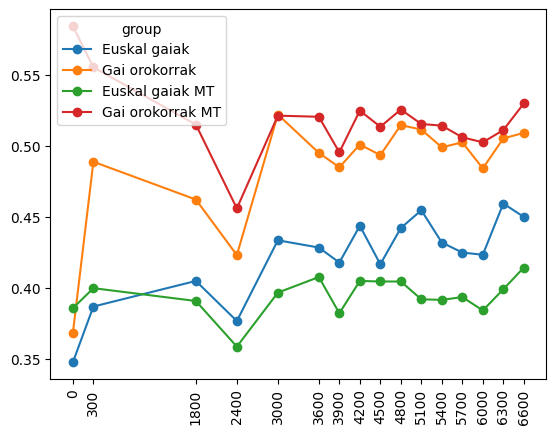

In [6]:
# plot accuracy per group
df_grouped_results = pd.DataFrame(grouped_results)
df_grouped_results.index = checkpoints_present
df_grouped_results_mt = pd.DataFrame(grouped_results_mt)
# change column names ro add MT
df_grouped_results_mt.columns = [f"{col} MT" for col in df_grouped_results_mt.columns]
df_grouped_results_mt.index = checkpoints_present

ax = df_grouped_results.plot(marker="o")
df_grouped_results_mt.plot(marker="o", ax=ax)
ax.set_xticks(checkpoints_present);
ax.set_xticklabels(checkpoints_present, rotation="vertical");


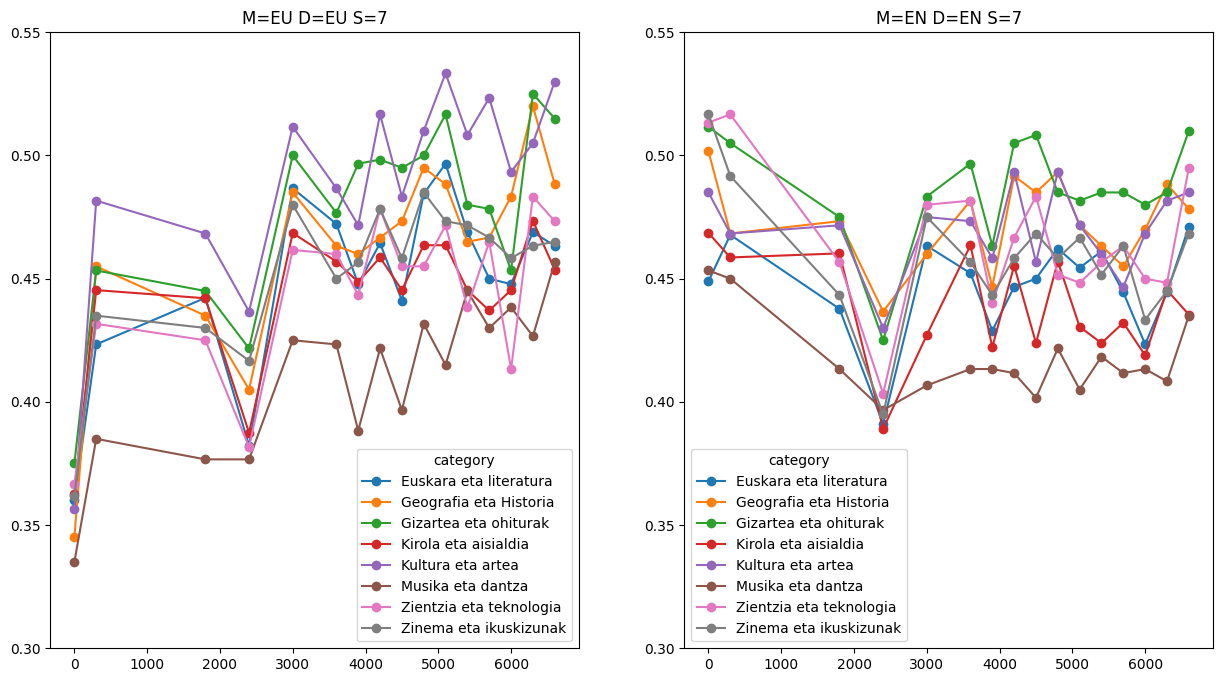

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# plot accuracy per category for EU
df_grouped_cat_results = pd.DataFrame(grouped_cat_results)
df_grouped_cat_results.index = checkpoints_present
df_grouped_cat_results.plot(marker="o", title="M=EU D=EU S=7", ax=ax1)
ax1.set_ylim([0.3, 0.55])

# plot accuracy per category for EN MT
df_grouped_cat_results_mt = pd.DataFrame(grouped_cat_results_mt)
df_grouped_cat_results_mt.index = checkpoints_present
df_grouped_cat_results_mt.plot(marker="o", title="M=EN D=EN S=7", ax=ax2)
ax2.set_ylim([0.3, 0.55])

plt.show()


## Results by Category

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_dataframe_eustrivia(df):
    # group by the "group" column and calculate the mean accuracy for each group
    # group attribute is in dict "doc"
    # combine Gai orokorrak and Nazioarteko gaiak into a single Gai orokorrak group
    df["group"] = df["doc"].apply(lambda x: x["group"] if x["group"] != "Nazioarteko gaiak" else "Gai orokorrak")
    grouped = df.groupby("group")["acc"].mean()

    # group by the "difficulty" column and calculate the mean accuracy for each difficulty
    # difficulty attribute is in dict "doc"
    df["difficulty"] = df["doc"].apply(lambda x: x["difficulty"])
    grouped_difficulty = df.groupby("difficulty")["acc"].mean()

    # group by the "category" column and calculate the mean accuracy for each category
    # category attribute is in dict "doc"
    df["category"] = df["doc"].apply(lambda x: x["category"])
    grouped_category = df.groupby("category")["acc"].mean()

    # group by the "group" and "category" columns and calculate the mean accuracy for each group and category combination
    grouped_group_category = df.groupby(["category", "group"])["acc"].mean()

    # group by the "difficulty" and "category" columns and calculate the mean accuracy for each difficulty and category combination
    grouped_difficulty_category = df.groupby(["category", "difficulty"])["acc"].mean()

    # group by the "group" and "difficulty" columns and calculate the mean accuracy for each group and difficulty combination
    grouped_group_difficulty = df.groupby(["difficulty", "group"])["acc"].mean()

    # plot the results
    fig, axs = plt.subplots(3, 2, figsize=(20, 20))
    grouped.plot(kind="bar", ax=axs[0, 0], rot=0, title="Accuracy by Group")
    grouped_difficulty.plot(kind="bar", ax=axs[0, 1], rot=0, title="Accuracy by Difficulty")
    grouped_category.plot(kind="bar", ax=axs[1, 0], rot=90, title="Accuracy by Category")
    
    grouped_group_category.unstack().plot(kind="bar", ax=axs[1, 1], rot=90, title="Accuracy by Category and Group")
    
    grouped_difficulty_category.unstack().plot(kind="bar", ax=axs[2, 0], rot=90, title="Accuracy by Difficulty and Category")
    
    grouped_group_difficulty.unstack().plot(kind="bar", ax=axs[2, 1], rot=0, title="Accuracy by Group and Difficulty")


In [9]:
df_eu = get_dataframe("llama-2-eu", "eustrivia")

df_eu_mt = get_dataframe("llama-2-eu", "eustrivia_mt")

df_eu_mt_itzuli = get_dataframe("llama-2-eu", "eustrivia_mt_itzuli")

df_eus_7b = get_dataframe("llama-2-eus", "eustrivia")

df_eus_13b = get_dataframe("llama-2-eus", "eustrivia", size=13)

df_eus_70b = get_dataframe("llama-2-eus", "eustrivia", size=70)

df_eus_mt_itzuli_7b = get_dataframe("llama-2-eus", "eustrivia_mt_itzuli")

df_eus_mt_itzuli_13b = get_dataframe("llama-2-eus", "eustrivia_mt_itzuli", size=13)

df_eus_mt_itzuli_70b = get_dataframe("llama-2-eus", "eustrivia_mt_itzuli", size=70)

df_eus_mt_elhuyar_7b = get_dataframe("llama-2-eus", "eustrivia_mt_elhuyar")

df_eus_mt_elhuyar_13b = get_dataframe("llama-2-eus", "eustrivia_mt_elhuyar", size=13)

df_eus_mt_elhuyar_70b = get_dataframe("llama-2-eus", "eustrivia_mt_elhuyar", size=70)

df_en = get_dataframe("llama-2", "eustrivia")

df_en_13b = get_dataframe("llama-2", "eustrivia", size=13)

df_en_70b = get_dataframe("llama-2", "eustrivia", size=70)

df_en_mt = get_dataframe("llama-2", "eustrivia_mt")

df_en_mt_itzuli = get_dataframe("llama-2", "eustrivia_mt_itzuli")

df_en_mt_itzuli_13b = get_dataframe("llama-2", "eustrivia_mt_itzuli", size=13)

df_en_mt_itzuli_70b = get_dataframe("llama-2", "eustrivia_mt_itzuli", size=70)

df_en_mt_elhuyar = get_dataframe("llama-2", "eustrivia_mt_elhuyar")

df_en_mt_elhuyar_13b = get_dataframe("llama-2", "eustrivia_mt_elhuyar", size=13)

df_en_mt_elhuyar_70b = get_dataframe("llama-2", "eustrivia_mt_elhuyar", size=70)

In [10]:
# merge three plots that correspond to different dataframes (df_en, df_eu and df_eu_mt) in a single plot, where each model is shown in a different color bar

def plot_eu_en_mt(df_eu, df_en_mt, df_eu_mt, df_en):
    merged = pd.DataFrame()
    merged["M=EU D=EU S=7"] = df_eu["acc"]
    merged["M=EN D=EN S=7"] = df_en_mt["acc"]
    merged["M=EU D=EN S=7"] = df_eu_mt["acc"]
    merged["M=EN D=EU S=7"] = df_en["acc"]
    merged["group"] = df_en_mt["doc"].apply(lambda x: x["group"] if x["group"] != "Nazioarteko gaiak" else "Gai orokorrak")
    merged["difficulty"] = df_en_mt["doc"].apply(lambda x: x["difficulty"])
    merged["category"] = df_en_mt["doc"].apply(lambda x: x["category"])

    merged_grouped = merged.groupby("group").mean()
    merged_grouped_difficulty = merged.groupby("difficulty").mean()
    merged_grouped_category = merged.groupby("category").mean()
    # remove difficulty from merged_grouped and merged_grouped_category
    merged_grouped.drop("difficulty", axis=1, inplace=True)
    merged_grouped_category.drop("difficulty", axis=1, inplace=True)

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    merged_grouped.plot(kind="bar", ax=axs[0], rot=0, title="Accuracy by Group")
    merged_grouped_difficulty.plot(kind="bar", ax=axs[1], rot=0, title="Accuracy by Difficulty")
    merged_grouped_category.plot(kind="bar", ax=axs[2], rot=90, title="Accuracy by Category")
    
    # add plot that combines group and category
    """
    merged_group_category = merged.groupby(["category", "group"]).mean()
    merged_group_category.drop("difficulty", axis=1, inplace=True)
    merged_group_category.plot(kind="bar", rot=90, title="Accuracy by Category and Group")
    # make this plot bigger
    plt.gcf().set_size_inches(20, 6)
    """

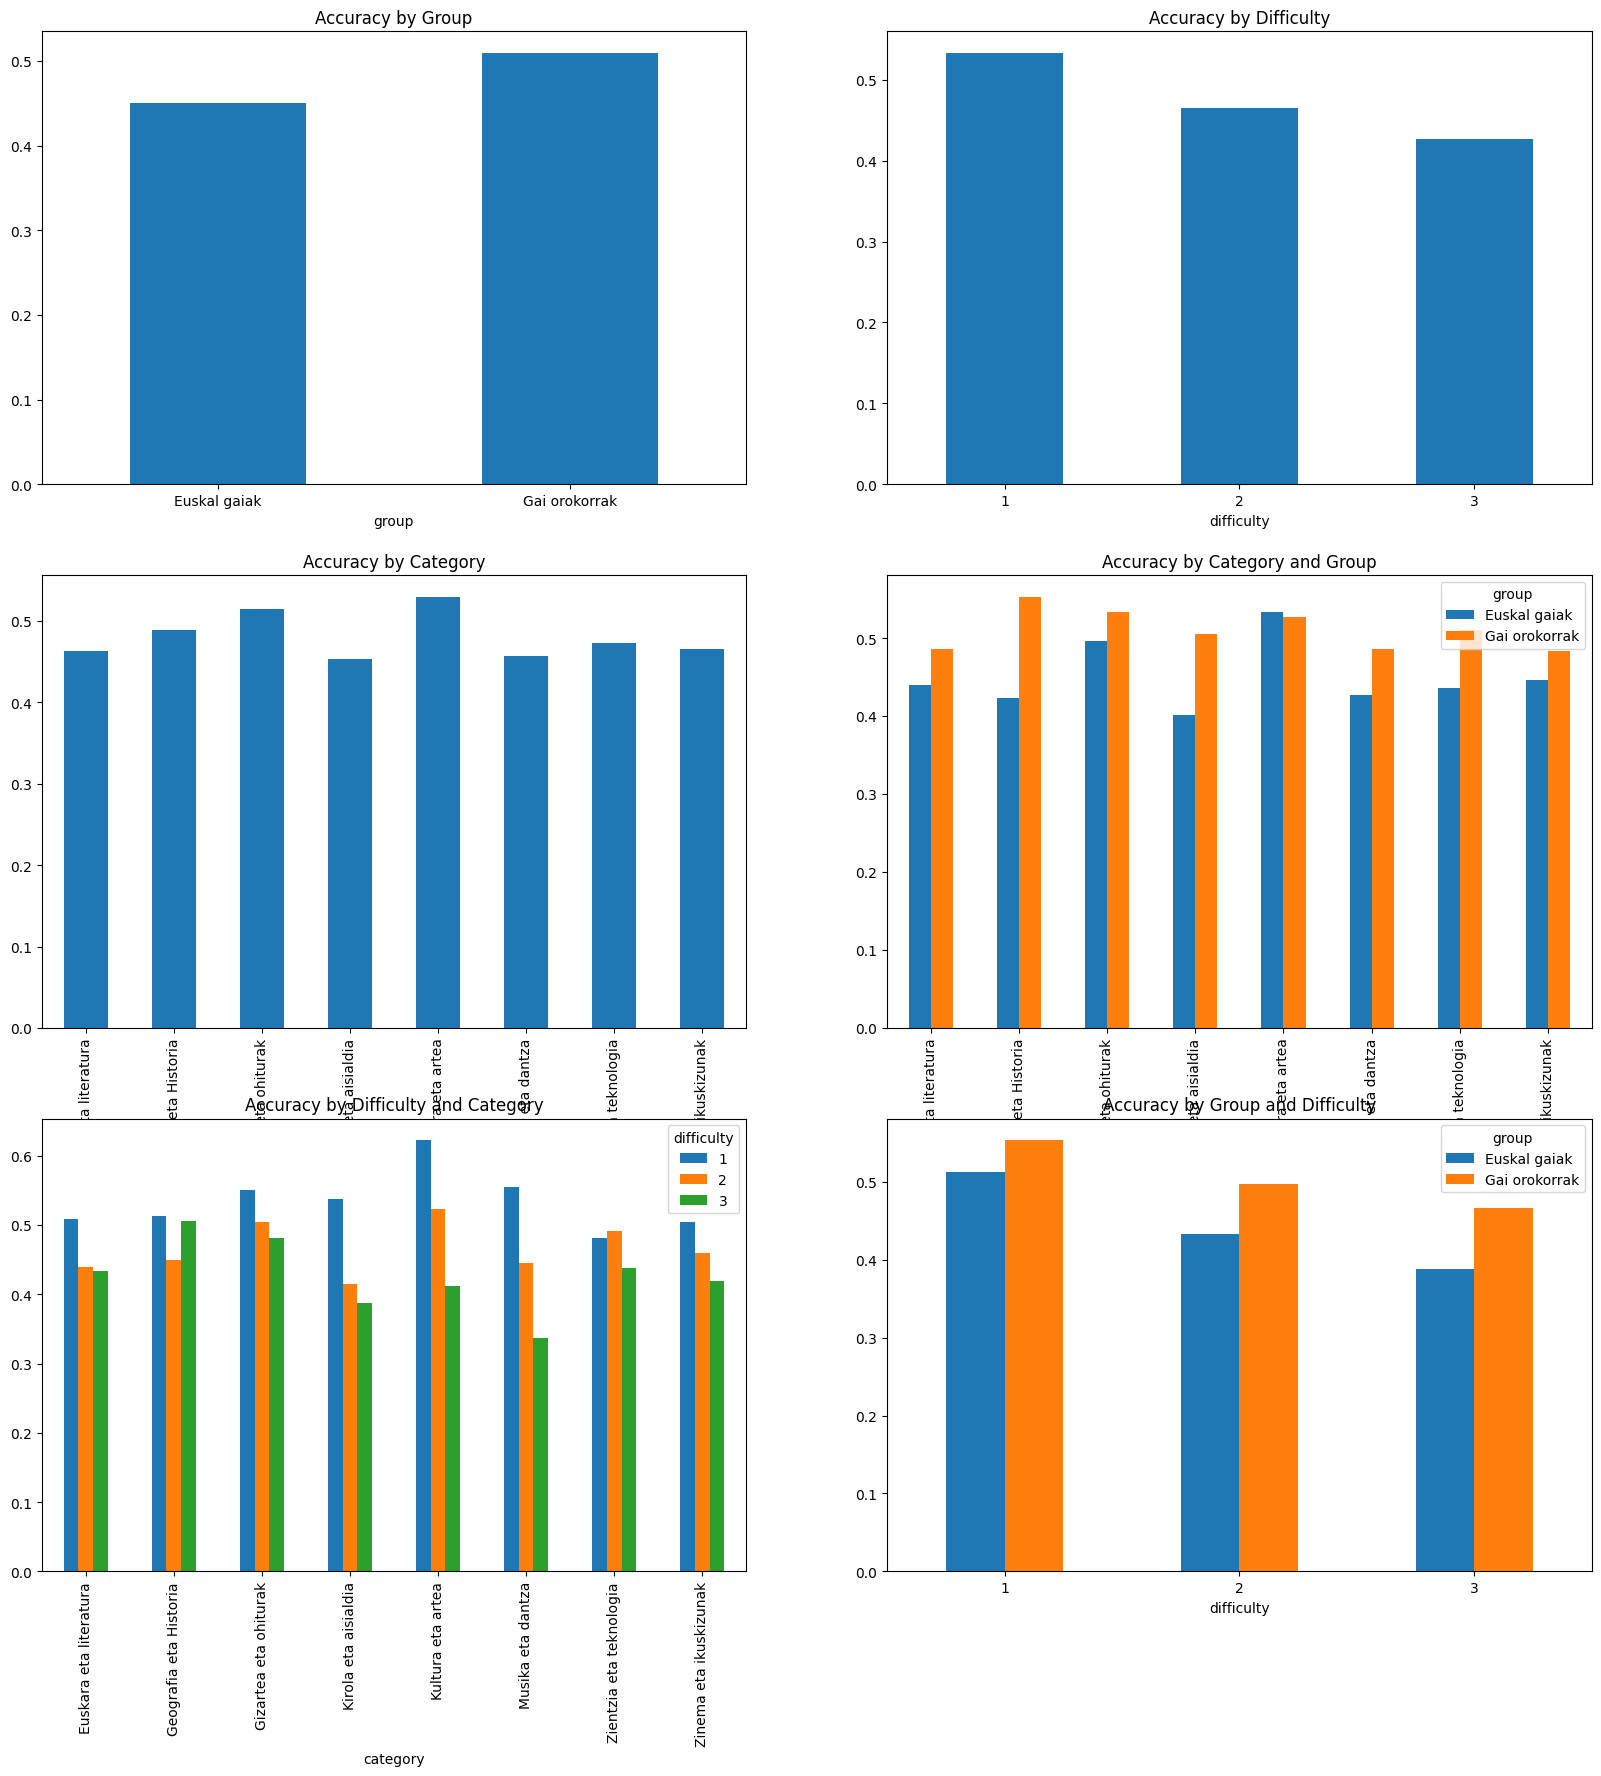

In [11]:
plot_dataframe_eustrivia(df_eu)


## Llama Eus 7B AitorO Eu vs En Itzuli

/tmp/ipykernel_4179521/2848250214.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped = merged.groupby("group").mean()
/tmp/ipykernel_4179521/2848250214.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_difficulty = merged.groupby("difficulty").mean()
/tmp/ipykernel_4179521/2848250214.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_category = merged.groupby("catego

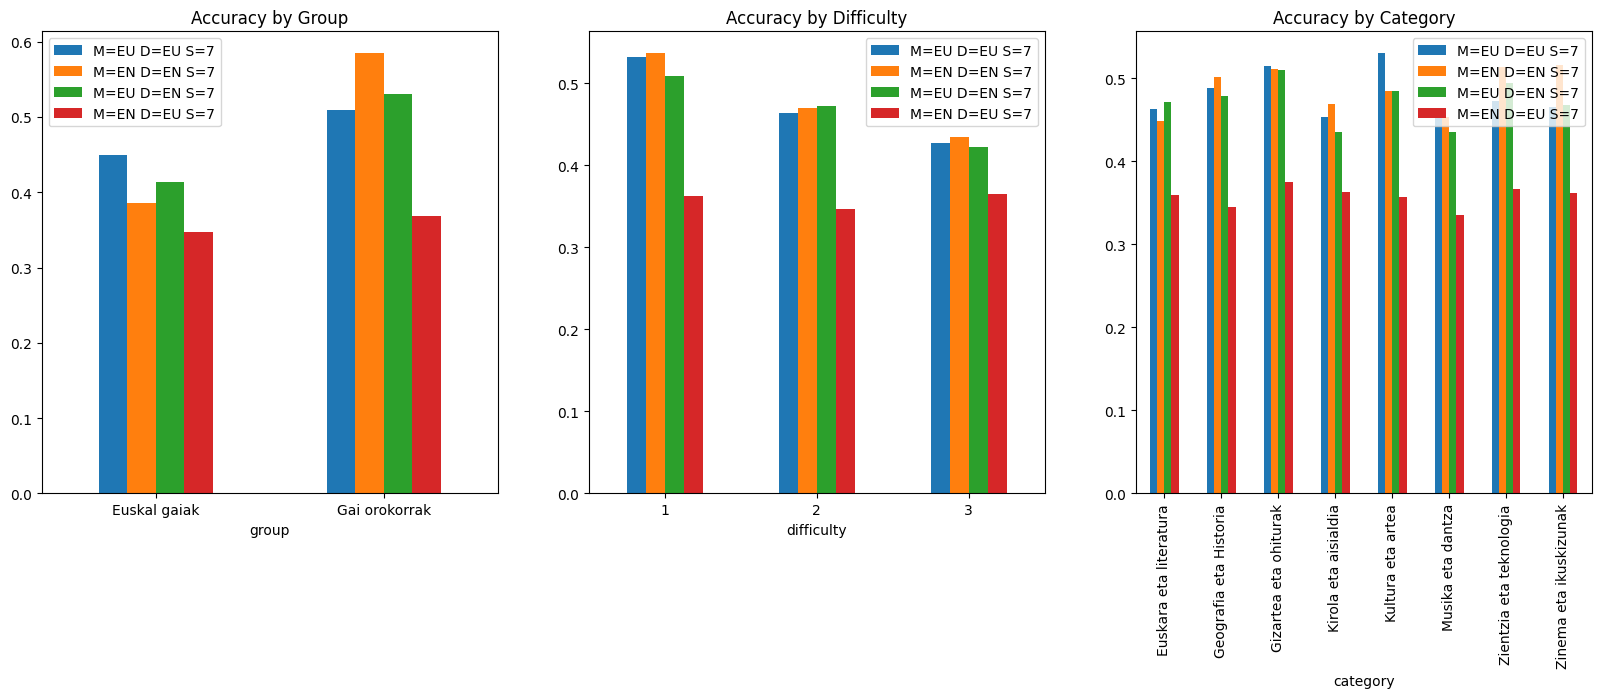

In [12]:
plot_eu_en_mt(df_eu, df_en_mt_itzuli, df_eu_mt_itzuli, df_en)

## Llama Base 7B, 13B, 70B Eu vs En Itzuli

In [13]:
def plot_eu_en_sizes(df_en, df_en_13b, df_en_70b, df_en_mt_itzuli, df_en_mt_itzuli_13b, df_en_mt_itzuli_70b):
    merged = pd.DataFrame()
    merged["M=EN D=EU S=7"] = df_en["acc"]
    merged["M=EN D=EU S=13"] = df_en_13b["acc"]
    merged["M=EN D=EU S=70"] = df_en_70b["acc"]
    merged["M=EN D=EN S=7"] = df_en_mt_itzuli["acc"]
    merged["M=EN D=EN S=13"] = df_en_mt_itzuli_13b["acc"]
    merged["M=EN D=EN S=70"] = df_en_mt_itzuli_70b["acc"]
    
    # plot average accuracy per model
    merged_mean = merged.mean()
    merged_mean.plot(kind="bar", rot=90, title="Average Accuracy per Model")
    display(merged_mean)
    
    merged["group"] = df_en_mt["doc"].apply(lambda x: x["group"] if x["group"] != "Nazioarteko gaiak" else "Gai orokorrak")
    merged["difficulty"] = df_en_mt["doc"].apply(lambda x: x["difficulty"])
    merged["category"] = df_en_mt["doc"].apply(lambda x: x["category"])
    
    merged_grouped = merged.groupby("group").mean()
    merged_grouped_difficulty = merged.groupby("difficulty").mean()
    merged_grouped_category = merged.groupby("category").mean()
    # remove difficulty from merged_grouped and merged_grouped_category
    merged_grouped.drop("difficulty", axis=1, inplace=True)
    merged_grouped_category.drop("difficulty", axis=1, inplace=True)

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    merged_grouped.plot(kind="bar", ax=axs[0], rot=0, title="Accuracy by Group")
    merged_grouped_difficulty.plot(kind="bar", ax=axs[2], rot=0, title="Accuracy by Difficulty")
    merged_grouped_category.plot(kind="bar", ax=axs[1], rot=90, title="Accuracy by Category")

    display(merged_grouped)
    
    # add plot that combines group and category
    """
    merged_group_category = merged.groupby(["category", "group"]).mean()
    merged_group_category.drop("difficulty", axis=1, inplace=True)
    merged_group_category.plot(kind="bar", rot=90, title="Accuracy by Category and Group")
    # make this plot bigger
    plt.gcf().set_size_inches(20, 6)
    """

M=EN D=EU S=7     0.357955
M=EN D=EU S=13    0.392633
M=EN D=EU S=70    0.450039
M=EN D=EN S=7     0.485110
M=EN D=EN S=13    0.527625
M=EN D=EN S=70    0.597375
dtype: float64

/tmp/ipykernel_4179521/1952666818.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped = merged.groupby("group").mean()
/tmp/ipykernel_4179521/1952666818.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_difficulty = merged.groupby("difficulty").mean()
/tmp/ipykernel_4179521/1952666818.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_category = merged.groupby("catego

,M=EN D=EU S=7,M=EN D=EU S=13,M=EN D=EU S=70,M=EN D=EN S=7,M=EN D=EN S=13,M=EN D=EN S=70
group,,,,,,
Euskal gaiak,0.347587,0.352687,0.371126,0.385641,0.406826,0.475481
Gai orokorrak,0.368297,0.432485,0.528767,0.584344,0.648141,0.718982


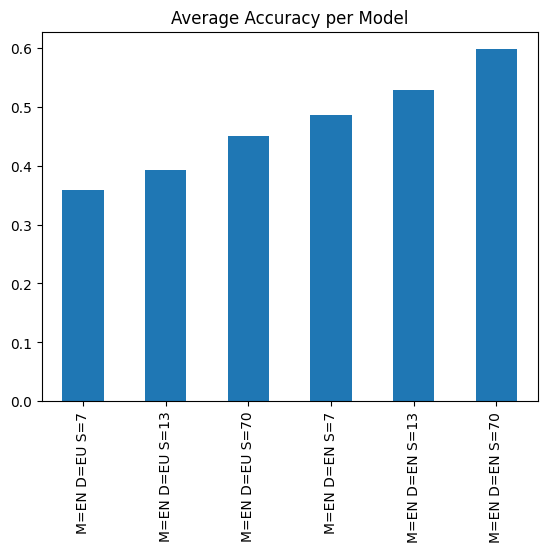

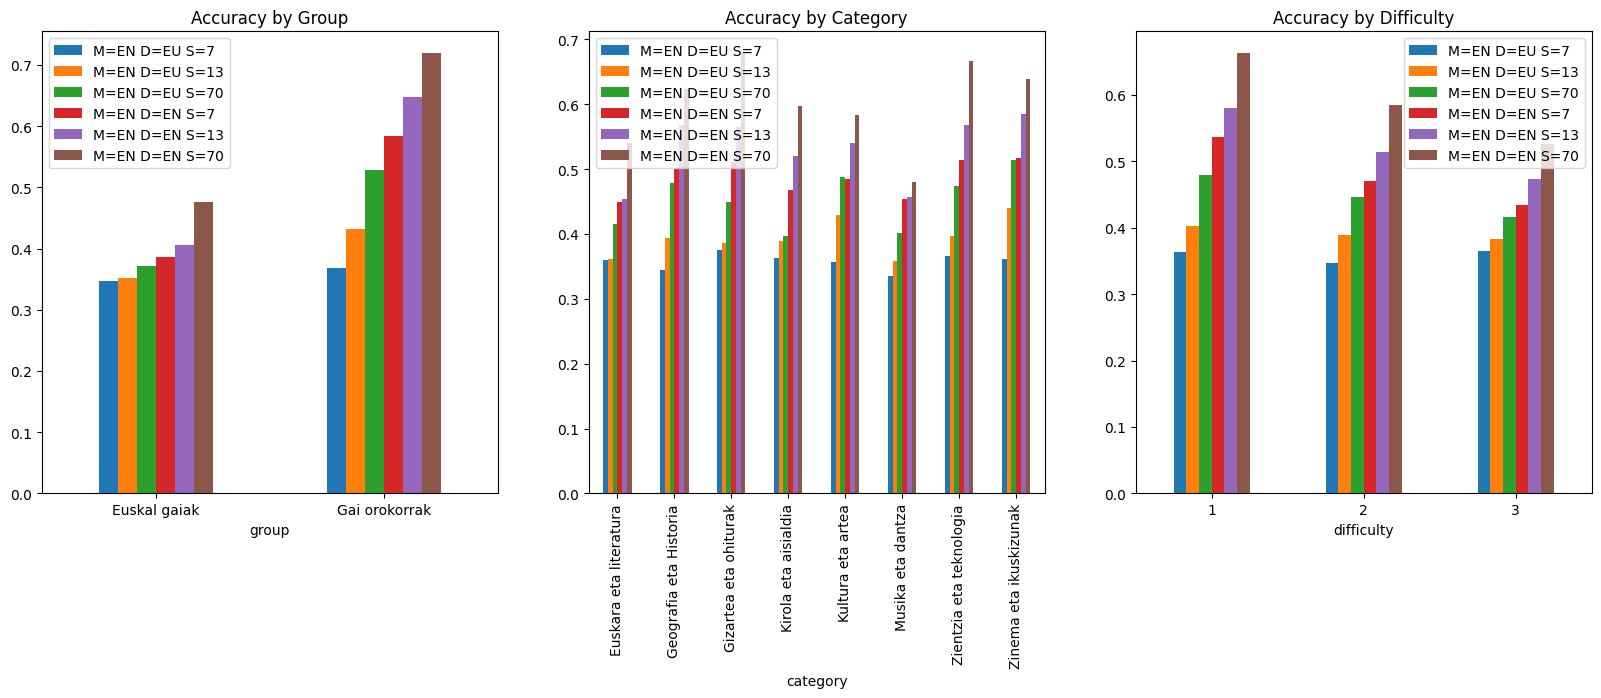

In [14]:
plot_eu_en_sizes(df_en, df_en_13b, df_en_70b, df_en_mt_itzuli, df_en_mt_itzuli_13b, df_en_mt_itzuli_70b)

## Llama Eus 7B, 13B, 70B EuroHPC Eu vs En Itzuli

In [60]:
def plot_eus_en_sizes(df_eus_7b, df_eus_13b, df_eus_70b, df_en_mt_itzuli, df_en_mt_itzuli_13b, df_en_mt_itzuli_70b):
    merged = pd.DataFrame()
    merged["M=EU D=EU S=7"] = df_eus_7b["acc"]
    merged["M=EU D=EU S=13"] = df_eus_13b["acc"]
    merged["M=EU D=EU S=70"] = df_eus_70b["acc"]
    merged["M=EN D=EN S=7"] = df_en_mt_itzuli["acc"]
    merged["M=EN D=EN S=13"] = df_en_mt_itzuli_13b["acc"]
    merged["M=EN D=EN S=70"] = df_en_mt_itzuli_70b["acc"]
    
    display(merged)
    
    # plot average accuracy per model
    merged_mean = merged.mean()
    merged_mean.plot(kind="bar", rot=90, title="Average Accuracy per Model")
    display((merged_mean* 100).round(2))

    merged["group"] = df_en_mt["doc"].apply(lambda x: x["group"] if x["group"] != "Nazioarteko gaiak" else "Gai orokorrak")
    merged["difficulty"] = df_en_mt["doc"].apply(lambda x: x["difficulty"])
    merged["category"] = df_en_mt["doc"].apply(lambda x: x["category"])

    merged_grouped = merged.groupby("group").mean()
    merged_grouped_difficulty = merged.groupby("difficulty").mean()
    merged_grouped_category = merged.groupby("category").mean()
    # remove difficulty from merged_grouped and merged_grouped_category
    merged_grouped.drop("difficulty", axis=1, inplace=True)
    merged_grouped_category.drop("difficulty", axis=1, inplace=True)

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    merged_grouped.plot(kind="bar", ax=axs[0], rot=0, title="Accuracy by Group")
    merged_grouped_difficulty.plot(kind="bar", ax=axs[2], rot=0, title="Accuracy by Difficulty")
    merged_grouped_category.plot(kind="bar", ax=axs[1], rot=90, title="Accuracy by Category")
    
    # multiply by 100 and round to 1 decimal place
    display((merged_grouped.T * 100).round(2))
    
    # add plot that combines group and category
    merged_group_category = merged.groupby(["category", "group"]).mean()
    merged_group_category.drop("difficulty", axis=1, inplace=True)
    merged_group_category.plot(kind="bar", rot=90, title="Accuracy by Category and Group")
    # make this plot bigger
    plt.gcf().set_size_inches(20, 6)
    display((merged_group_category.T * 100).round(2))

,M=EU D=EU S=7,M=EU D=EU S=13,M=EU D=EU S=70,M=EN D=EN S=7,M=EN D=EN S=13,M=EN D=EN S=70
0,1,0,1,1,1,1
1,1,0,1,0,0,0
2,1,1,1,1,1,1
3,0,1,1,1,1,1
4,1,1,1,1,1,0
...,...,...,...,...,...,...
5099,0,0,0,1,0,0
5100,0,0,0,0,0,0
5101,1,1,1,1,0,1
5102,1,1,1,1,0,1


M=EU D=EU S=7     49.22
M=EU D=EU S=13    58.70
M=EU D=EU S=70    64.24
M=EN D=EN S=7     48.51
M=EN D=EN S=13    52.76
M=EN D=EN S=70    59.74
dtype: float64

/tmp/ipykernel_4179521/1898386133.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped = merged.groupby("group").mean()
/tmp/ipykernel_4179521/1898386133.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_difficulty = merged.groupby("difficulty").mean()
/tmp/ipykernel_4179521/1898386133.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_category = merged.groupby("catego

group,Euskal gaiak,Gai orokorrak
M=EU D=EU S=7,45.74,52.68
M=EU D=EU S=13,53.71,63.68
M=EU D=EU S=70,59.36,69.12
M=EN D=EN S=7,38.56,58.43
M=EN D=EN S=13,40.68,64.81
M=EN D=EN S=70,47.55,71.90


category       Euskara eta literatura               Geografia eta Historia  \
group                    Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                   47.56         51.11                  45.00   
M=EU D=EU S=13                  56.67         60.00                  51.67   
M=EU D=EU S=70                  65.11         63.56                  57.67   
M=EN D=EN S=7                   42.00         47.78                  36.33   
M=EN D=EN S=13                  40.00         50.89                  40.67   
M=EN D=EN S=70                  48.22         59.78                  46.00   

category                     Gizartea eta ohiturak                \
group          Gai orokorrak          Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          55.67                 50.00         50.33   
M=EU D=EU S=13         68.00                 61.67         65.33   
M=EU D=EU S=70         70.67                 68.67         77.67   
M=EN D=EN S=7          64.00                 39.00         63.33   
M=EN D=EN S=13         73.00                 42.00         71.00   
M=EN D=EN S=70         78.67                 54.00         81.67   

category       Kirola eta aisialdia               Kultura eta artea  \
group                  Euskal gaiak Gai orokorrak      Euskal gaiak   
M=EU D=EU S=7                 43.14         50.16             48.67   
M=EU D=EU S=13                48.83         62.95             59.00   
M=EU D=EU S=70                53.85         70.82             59.33   
M=EN D=EN S=7                 36.79         56.72             36.67   
M=EN D=EN S=13                37.12         66.56             40.00   
M=EN D=EN S=70                48.49         70.82             44.33   

category                     Musika eta dantza                \
group          Gai orokorrak      Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          60.33             42.67         49.00   
M=EU D=EU S=13         68.33             45.00         53.33   
M=EU D=EU S=70         70.33             47.67         59.33   
M=EN D=EN S=7          60.33             36.33         54.33   
M=EN D=EN S=13         68.00             34.00         57.33   
M=EN D=EN S=70         72.33             34.67         61.33   

category       Zientzia eta teknologia               Zinema eta ikuskizunak  \
group                     Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                    45.33         54.33                  42.67   
M=EU D=EU S=13                   52.67         66.00                  52.67   
M=EU D=EU S=70                   60.67         72.67                  59.00   
M=EN D=EN S=7                    41.00         61.67                  38.67   
M=EN D=EN S=13                   47.67         66.00                  44.33   
M=EN D=EN S=70                   55.67         77.67                  48.67   

category                      
group          Gai orokorrak  
M=EU D=EU S=7          51.33  
M=EU D=EU S=13         67.33  
M=EU D=EU S=70         70.67  
M=EN D=EN S=7          64.67  
M=EN D=EN S=13         72.67  
M=EN D=EN S=70         79.00

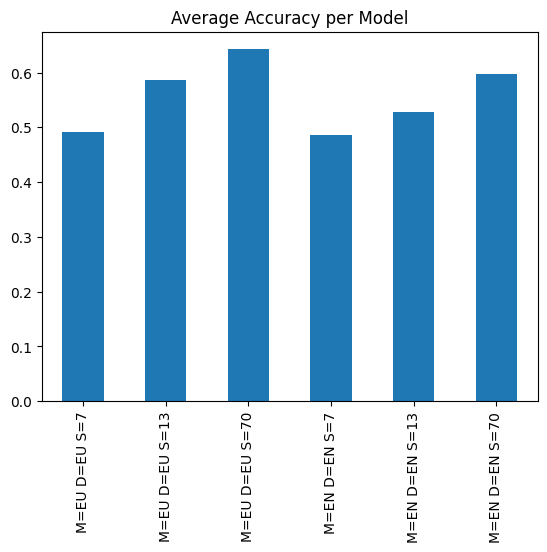

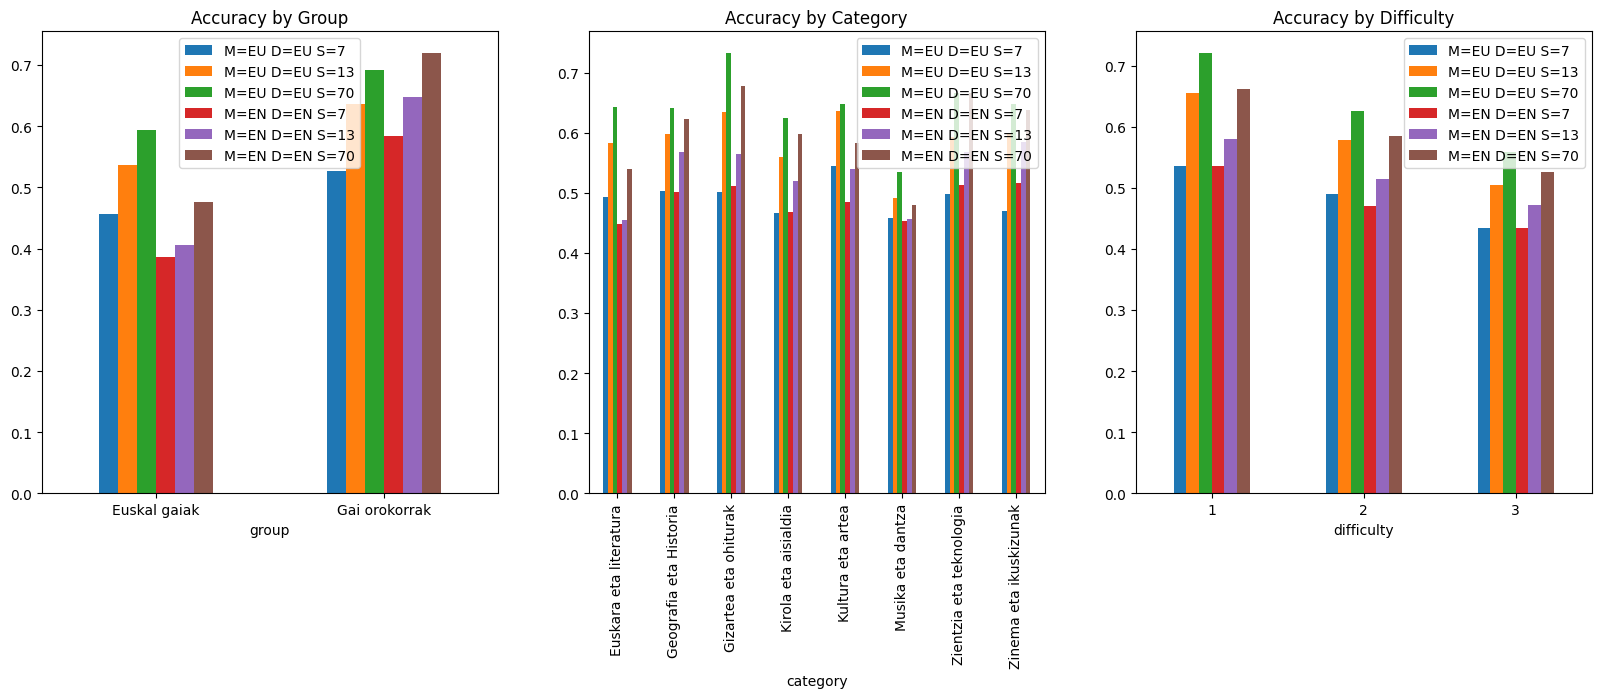

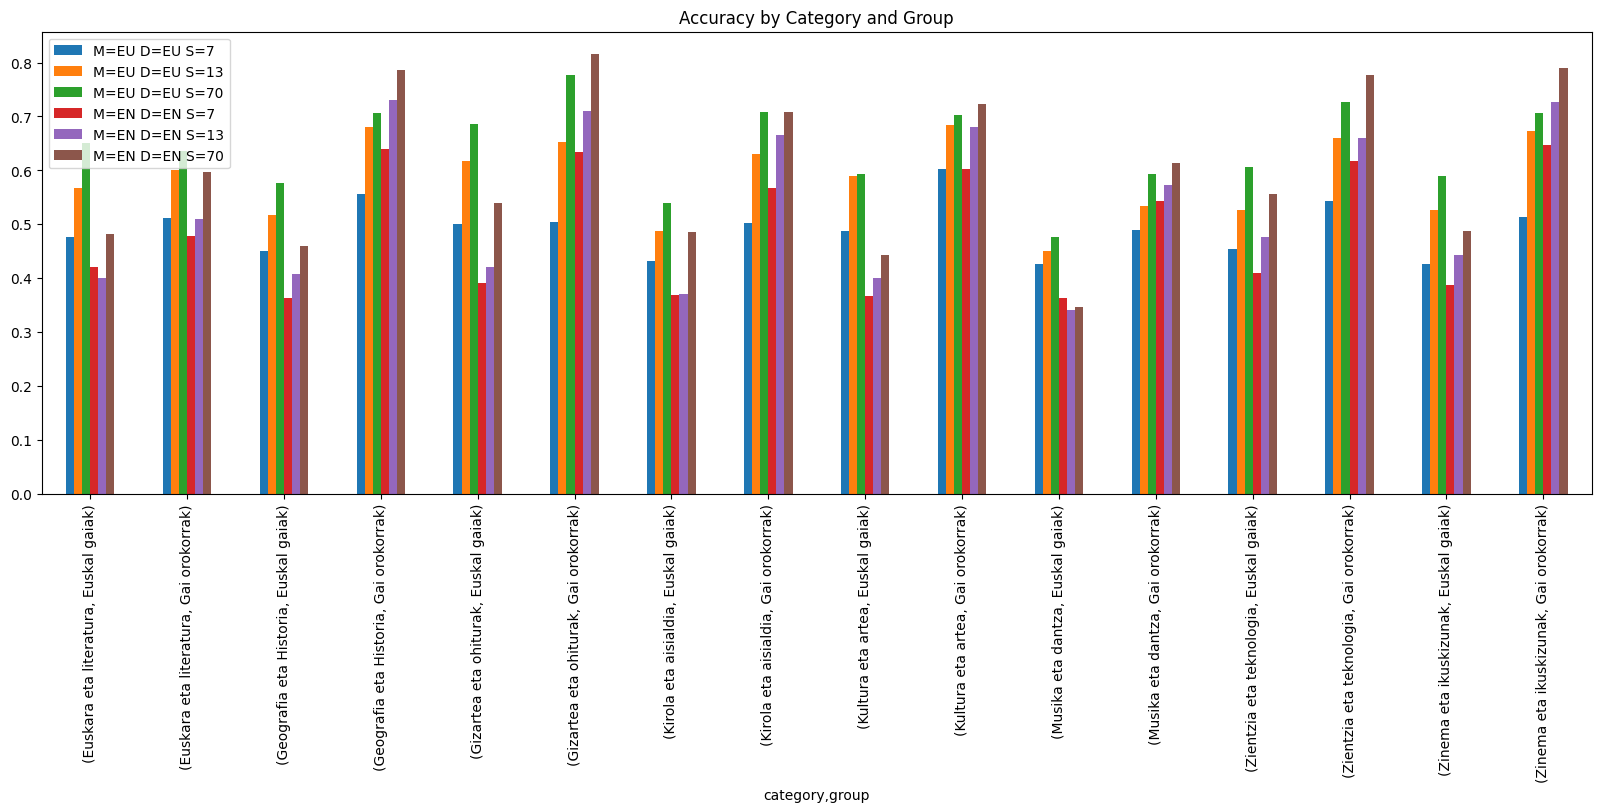

In [61]:
plot_eus_en_sizes(df_eus_7b, df_eus_13b, df_eus_70b, df_en_mt_itzuli, df_en_mt_itzuli_13b, df_en_mt_itzuli_70b)

## Llama Eus 7B, 13B, 70B EuroHPC Eu vs En Elhuyar Filtered

,M=EU D=EU S=7,M=EU D=EU S=13,M=EU D=EU S=70,M=EN D=EN S=7,M=EN D=EN S=13,M=EN D=EN S=70
0,1,0,1,0,0,1
1,1,0,1,1,1,1
2,1,1,1,0,1,1
3,0,1,1,1,1,1
5,0,1,1,0,0,0
...,...,...,...,...,...,...
1994,0,0,0,0,0,0
1995,0,0,0,0,0,0
1997,1,0,1,1,1,1
1998,0,0,1,0,0,1


M=EU D=EU S=7     49.66
M=EU D=EU S=13    60.36
M=EU D=EU S=70    64.71
M=EN D=EN S=7     52.09
M=EN D=EN S=13    58.03
M=EN D=EN S=70    61.69
dtype: float64

/tmp/ipykernel_4179521/1898386133.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped = merged.groupby("group").mean()
/tmp/ipykernel_4179521/1898386133.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_difficulty = merged.groupby("difficulty").mean()
/tmp/ipykernel_4179521/1898386133.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_category = merged.groupby("catego

group,Euskal gaiak,Gai orokorrak
M=EU D=EU S=7,45.38,54.11
M=EU D=EU S=13,55.35,65.58
M=EU D=EU S=70,58.67,71.00
M=EN D=EN S=7,40.39,64.29
M=EN D=EN S=13,44.44,72.19
M=EN D=EN S=70,46.94,77.06


category       Euskara eta literatura               Geografia eta Historia  \
group                    Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                   51.26         58.06                  43.10   
M=EU D=EU S=13                  62.18         63.71                  48.28   
M=EU D=EU S=70                  68.07         72.58                  54.31   
M=EN D=EN S=7                   42.86         59.68                  33.62   
M=EN D=EN S=13                  37.82         58.87                  38.79   
M=EN D=EN S=70                  36.13         70.16                  47.41   

category                     Gizartea eta ohiturak                \
group          Gai orokorrak          Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          55.65                 46.09         58.33   
M=EU D=EU S=13         71.30                 64.06         70.83   
M=EU D=EU S=70         73.04                 68.75         77.50   
M=EN D=EN S=7          67.83                 36.72         65.00   
M=EN D=EN S=13         77.39                 46.09         82.50   
M=EN D=EN S=70         83.48                 53.12         85.83   

category       Kirola eta aisialdia               Kultura eta artea  \
group                  Euskal gaiak Gai orokorrak      Euskal gaiak   
M=EU D=EU S=7                 41.59         51.79             48.70   
M=EU D=EU S=13                45.13         62.50             63.48   
M=EU D=EU S=70                50.44         70.54             55.65   
M=EN D=EN S=7                 36.28         61.61             46.09   
M=EN D=EN S=13                42.48         66.96             47.83   
M=EN D=EN S=70                47.79         76.79             44.35   

category                     Musika eta dantza                \
group          Gai orokorrak      Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          54.13             40.95         49.57   
M=EU D=EU S=13         66.06             47.62         57.39   
M=EU D=EU S=70         72.48             49.52         57.39   
M=EN D=EN S=7          65.14             32.38         55.65   
M=EN D=EN S=13         69.72             35.24         65.22   
M=EN D=EN S=70         77.98             40.95         66.96   

category       Zientzia eta teknologia               Zinema eta ikuskizunak  \
group                     Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                    45.19         52.25                  45.45   
M=EU D=EU S=13                   52.59         65.77                  57.58   
M=EU D=EU S=70                   61.48         73.87                  58.33   
M=EN D=EN S=7                    49.63         66.67                  43.18   
M=EN D=EN S=13                   56.30         74.77                  47.73   
M=EN D=EN S=70                   58.52         81.08                  44.70   

category                      
group          Gai orokorrak  
M=EU D=EU S=7          52.54  
M=EU D=EU S=13         66.95  
M=EU D=EU S=70         70.34  
M=EN D=EN S=7          72.88  
M=EN D=EN S=13         82.20  
M=EN D=EN S=70         74.58

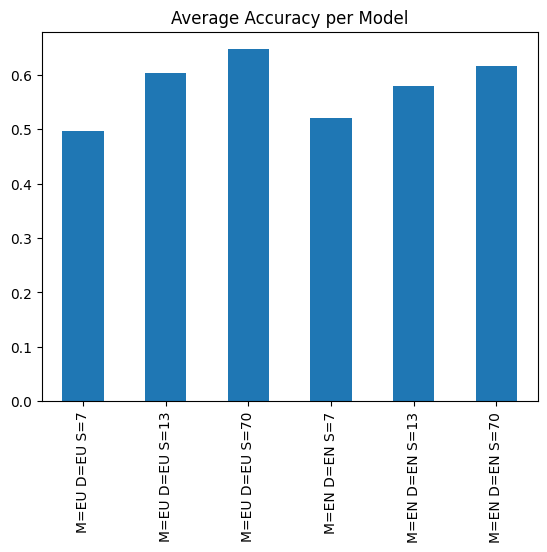

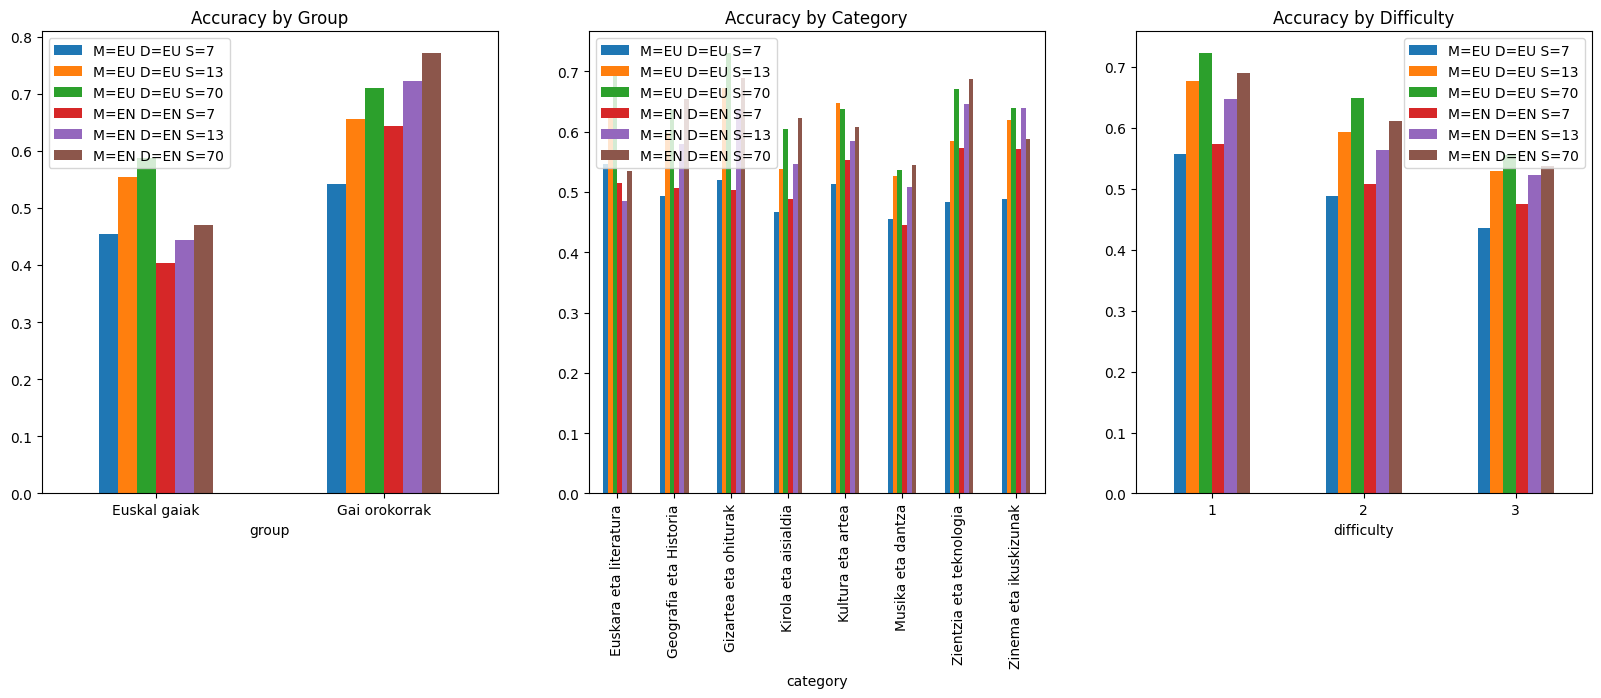

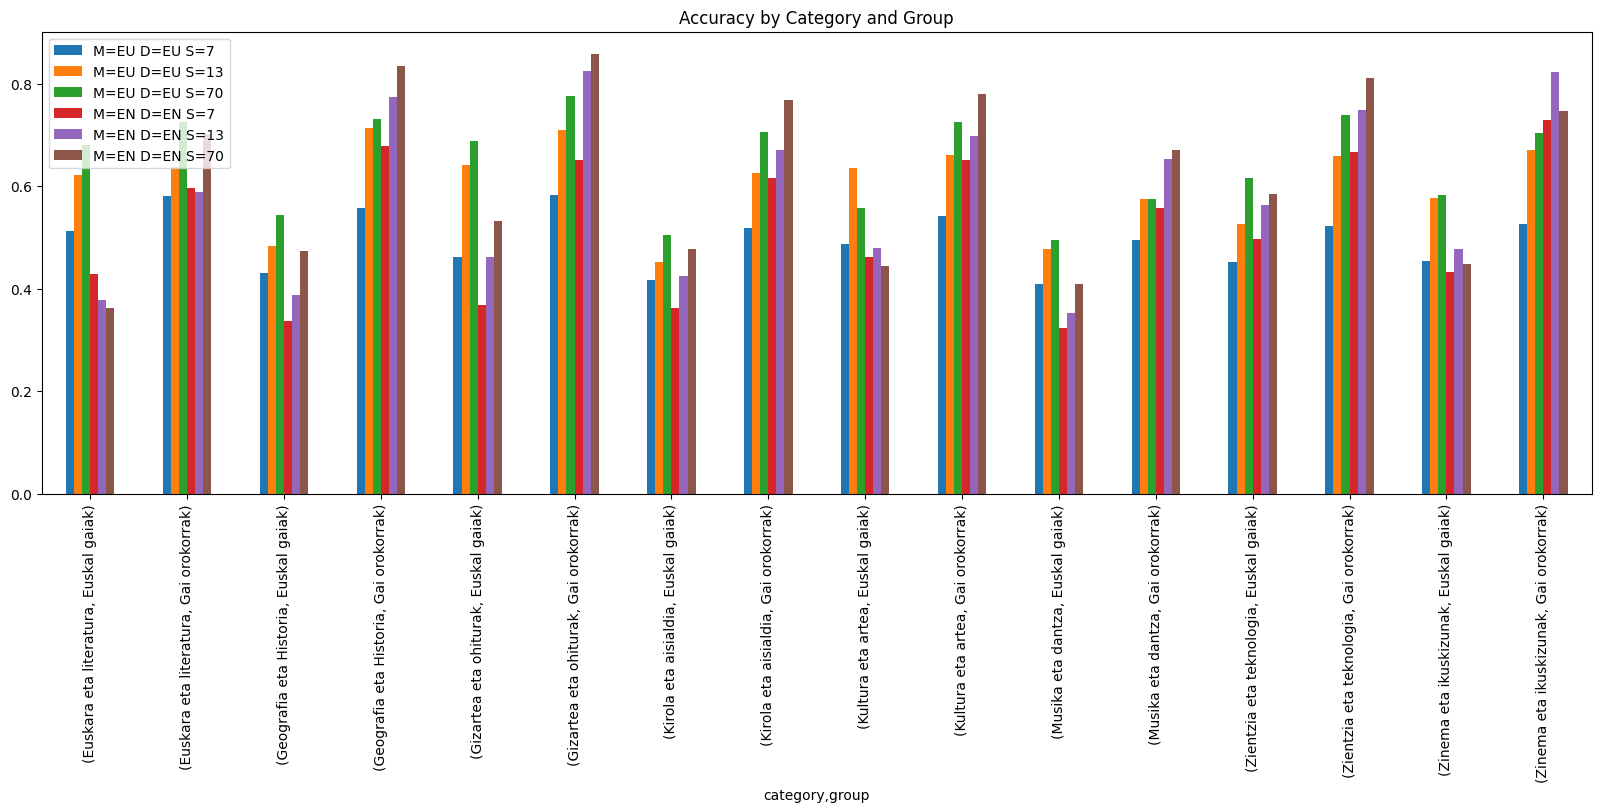

In [62]:
# get ids that are present in elhuyar dataframe

def get_ids(df):
    ids = df["doc"].apply(lambda x: x["id"])
    return ids

ids = get_ids(df_en_mt_elhuyar)

# filter other dataframe to only include those for a fair comparison
df_eus_7b_filtered = df_eus_7b[df_eus_7b["doc"].apply(lambda x: x["id"] in ids.values)]
df_eus_13b_filtered = df_eus_13b[df_eus_13b["doc"].apply(lambda x: x["id"] in ids.values)]
df_eus_70b_filtered = df_eus_70b[df_eus_70b["doc"].apply(lambda x: x["id"] in ids.values)]

# change elhuyar index to doc id
df_en_mt_elhuyar.index = df_en_mt_elhuyar["doc"].apply(lambda x: x["id"])
df_en_mt_elhuyar_13b.index = df_en_mt_elhuyar_13b["doc"].apply(lambda x: x["id"])
df_en_mt_elhuyar_70b.index = df_en_mt_elhuyar_70b["doc"].apply(lambda x: x["id"])

plot_eus_en_sizes(df_eus_7b_filtered, df_eus_13b_filtered, df_eus_70b_filtered, df_en_mt_elhuyar, df_en_mt_elhuyar_13b, df_en_mt_elhuyar_70b)

## Llama Eus 7B, 13B, 70B EuroHPC Eu vs En Itzuli Filtered

,M=EU D=EU S=7,M=EU D=EU S=13,M=EU D=EU S=70,M=EN D=EN S=7,M=EN D=EN S=13,M=EN D=EN S=70
0,1,0,1,1,1,1
1,1,0,1,0,0,0
2,1,1,1,1,1,1
3,0,1,1,1,1,1
5,0,1,1,0,1,0
...,...,...,...,...,...,...
1994,0,0,0,0,0,0
1995,0,0,0,1,0,0
1997,1,0,1,1,1,1
1998,0,0,1,0,1,1


M=EU D=EU S=7     49.66
M=EU D=EU S=13    60.36
M=EU D=EU S=70    64.71
M=EN D=EN S=7     49.02
M=EN D=EN S=13    55.27
M=EN D=EN S=70    60.41
dtype: float64

/tmp/ipykernel_4179521/1898386133.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped = merged.groupby("group").mean()
/tmp/ipykernel_4179521/1898386133.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_difficulty = merged.groupby("difficulty").mean()
/tmp/ipykernel_4179521/1898386133.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_category = merged.groupby("catego

group,Euskal gaiak,Gai orokorrak
M=EU D=EU S=7,45.38,54.11
M=EU D=EU S=13,55.35,65.58
M=EU D=EU S=70,58.67,71.00
M=EN D=EN S=7,39.67,58.77
M=EN D=EN S=13,43.41,67.64
M=EN D=EN S=70,47.87,73.48


category       Euskara eta literatura               Geografia eta Historia  \
group                    Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                   51.26         58.06                  43.10   
M=EU D=EU S=13                  62.18         63.71                  48.28   
M=EU D=EU S=70                  68.07         72.58                  54.31   
M=EN D=EN S=7                   47.06         49.19                  34.48   
M=EN D=EN S=13                  42.86         56.45                  41.38   
M=EN D=EN S=70                  42.86         63.71                  45.69   

category                     Gizartea eta ohiturak                \
group          Gai orokorrak          Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          55.65                 46.09         58.33   
M=EU D=EU S=13         71.30                 64.06         70.83   
M=EU D=EU S=70         73.04                 68.75         77.50   
M=EN D=EN S=7          59.13                 37.50         66.67   
M=EN D=EN S=13         72.17                 39.84         75.83   
M=EN D=EN S=70         81.74                 55.47         84.17   

category       Kirola eta aisialdia               Kultura eta artea  \
group                  Euskal gaiak Gai orokorrak      Euskal gaiak   
M=EU D=EU S=7                 41.59         51.79             48.70   
M=EU D=EU S=13                45.13         62.50             63.48   
M=EU D=EU S=70                50.44         70.54             55.65   
M=EN D=EN S=7                 34.51         53.57             38.26   
M=EN D=EN S=13                36.28         63.39             42.61   
M=EN D=EN S=70                46.90         73.21             49.57   

category                     Musika eta dantza                \
group          Gai orokorrak      Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          54.13             40.95         49.57   
M=EU D=EU S=13         66.06             47.62         57.39   
M=EU D=EU S=70         72.48             49.52         57.39   
M=EN D=EN S=7          57.80             35.24         53.04   
M=EN D=EN S=13         70.64             39.05         60.87   
M=EN D=EN S=70         67.89             38.10         57.39   

category       Zientzia eta teknologia               Zinema eta ikuskizunak  \
group                     Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                    45.19         52.25                  45.45   
M=EU D=EU S=13                   52.59         65.77                  57.58   
M=EU D=EU S=70                   61.48         73.87                  58.33   
M=EN D=EN S=7                    44.44         63.06                  43.94   
M=EN D=EN S=13                   52.59         68.47                  50.00   
M=EN D=EN S=70                   59.26         81.08                  42.42   

category                      
group          Gai orokorrak  
M=EU D=EU S=7          52.54  
M=EU D=EU S=13         66.95  
M=EU D=EU S=70         70.34  
M=EN D=EN S=7          67.80  
M=EN D=EN S=13         73.73  
M=EN D=EN S=70         78.81

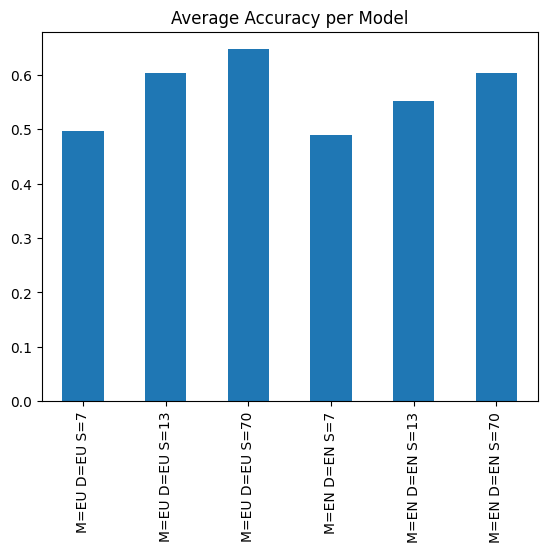

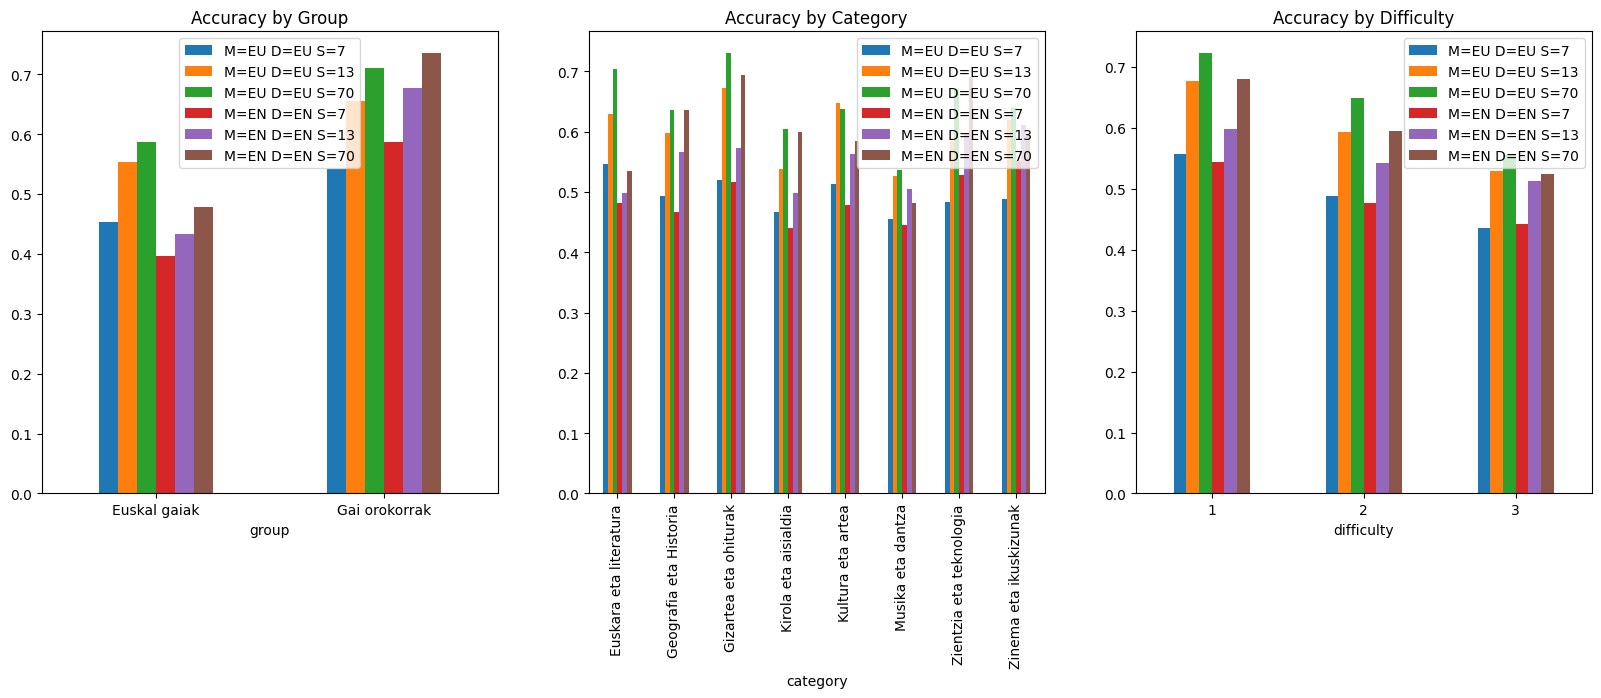

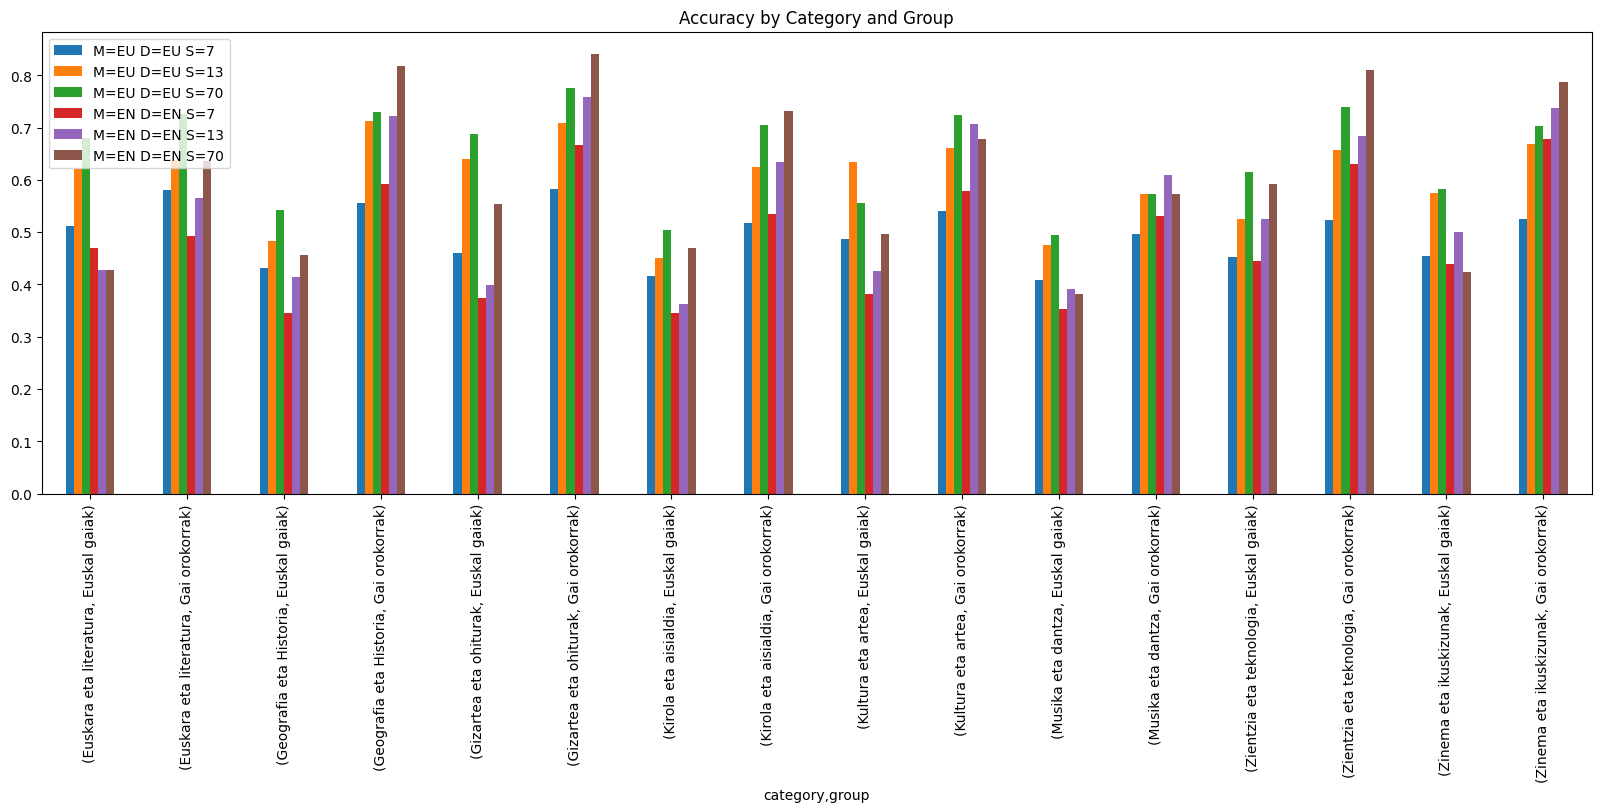

In [66]:
# filter itzuli dataframe to only include those for a fair comparison

df_en_mt_itzuli_filtered = df_en_mt_itzuli[df_en_mt_itzuli["doc"].apply(lambda x: x["id"] in ids.values)]
df_en_mt_itzuli_13b_filtered = df_en_mt_itzuli_13b[df_en_mt_itzuli_13b["doc"].apply(lambda x: x["id"] in ids.values)]
df_en_mt_itzuli_70b_filtered = df_en_mt_itzuli_70b[df_en_mt_itzuli_70b["doc"].apply(lambda x: x["id"] in ids.values)]

plot_eus_en_sizes(df_eus_7b_filtered, df_eus_13b_filtered, df_eus_70b_filtered, df_en_mt_itzuli_filtered, df_en_mt_itzuli_13b_filtered, df_en_mt_itzuli_70b_filtered)

In [67]:
df_en_mt_itzuli_filtered

,doc_id,doc,target,arguments,resps,filtered_resps,acc,acc_norm
0,0,"{'id': 0, 'category': 'Geografia eta Historia'...",0,[[Question: Who won the XXIV Passepartout. Aur...,"[[[-0.726975739002227, True]], [[-0.9144757390...","[[-0.726975739002227, True], [-0.9144757390022...",1,1
1,1,"{'id': 1, 'category': 'Zinema eta ikuskizunak'...",1,[[Question: When was the painter Jose Luis Zum...,"[[[-0.6766531467437741, True]], [[-1.332903146...","[[-0.6766531467437741, True], [-1.332903146743...",0,0
2,2,"{'id': 2, 'category': 'Geografia eta Historia'...",0,[[Question: What is Iker Arretxe for Fernando ...,"[[[-0.56506872177124, True]], [[-1.22131872177...","[[-0.56506872177124, True], [-1.22131872177124...",1,1
3,3,"{'id': 3, 'category': 'Euskara eta literatura'...",1,[[Question: The Arabic of the past resembled a...,"[[[-1.155009984970092, False]], [[-0.795634925...","[[-1.155009984970092, False], [-0.795634925365...",1,1
5,5,"{'id': 5, 'category': 'Zinema eta ikuskizunak'...",2,[[Question: What is the name of the set of sci...,"[[[-0.6570307016372681, True]], [[-1.328905701...","[[-0.6570307016372681, True], [-1.328905701637...",0,0
...,...,...,...,...,...,...,...,...
1994,1994,"{'id': 1994, 'category': 'Musika eta dantza', ...",2,[[Question: Where's the Tretiakov gallery?\nA:...,"[[[-0.8193442821502681, True]], [[-1.100594282...","[[-0.8193442821502681, True], [-1.100594282150...",0,0
1995,1995,"{'id': 1995, 'category': 'Musika eta dantza', ...",1,[[Question: Which group is singer Chris Martin...,"[[[-1.259827136993408, False]], [[-0.744202077...","[[-1.259827136993408, False], [-0.744202077388...",1,1
1997,1997,"{'id': 1997, 'category': 'Kultura eta artea', ...",0,[[Question: One of these three is from another...,"[[[-0.873453617095947, True]], [[-1.2328286170...","[[-0.873453617095947, True], [-1.2328286170959...",1,1
1998,1998,"{'id': 1998, 'category': 'Kultura eta artea', ...",2,[[Question: Which of these is a Koniker line o...,"[[[-1.029623985290527, True]], [[-1.0608739852...","[[-1.029623985290527, True], [-1.0608739852905...",0,0


## Llama Eus 7B, 13B, 70B EuroHPC Eu vs Base Eu Filtered


,M=EU D=EU S=7,M=EU D=EU S=13,M=EU D=EU S=70,M=EN D=EN S=7,M=EN D=EN S=13,M=EN D=EN S=70
0,1,0,1,1,0,1
1,1,0,1,0,1,1
2,1,1,1,0,0,0
3,0,1,1,1,1,1
5,0,1,1,0,1,0
...,...,...,...,...,...,...
1994,0,0,0,0,0,0
1995,0,0,0,1,0,0
1997,1,0,1,0,0,1
1998,0,0,1,0,0,1


M=EU D=EU S=7     49.66
M=EU D=EU S=13    60.36
M=EU D=EU S=70    64.71
M=EN D=EN S=7     36.51
M=EN D=EN S=13    40.86
M=EN D=EN S=70    46.16
dtype: float64

/tmp/ipykernel_4179521/1898386133.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped = merged.groupby("group").mean()
/tmp/ipykernel_4179521/1898386133.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_difficulty = merged.groupby("difficulty").mean()
/tmp/ipykernel_4179521/1898386133.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_category = merged.groupby("catego

group,Euskal gaiak,Gai orokorrak
M=EU D=EU S=7,45.38,54.11
M=EU D=EU S=13,55.35,65.58
M=EU D=EU S=70,58.67,71.00
M=EN D=EN S=7,34.79,38.31
M=EN D=EN S=13,36.86,45.02
M=EN D=EN S=70,38.01,54.65


category       Euskara eta literatura               Geografia eta Historia  \
group                    Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                   51.26         58.06                  43.10   
M=EU D=EU S=13                  62.18         63.71                  48.28   
M=EU D=EU S=70                  68.07         72.58                  54.31   
M=EN D=EN S=7                   39.50         40.32                  26.72   
M=EN D=EN S=13                  43.70         45.16                  31.90   
M=EN D=EN S=70                  39.50         51.61                  28.45   

category                     Gizartea eta ohiturak                \
group          Gai orokorrak          Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          55.65                 46.09         58.33   
M=EU D=EU S=13         71.30                 64.06         70.83   
M=EU D=EU S=70         73.04                 68.75         77.50   
M=EN D=EN S=7          36.52                 39.06         38.33   
M=EN D=EN S=13         45.22                 35.16         39.17   
M=EN D=EN S=70         61.74                 38.28         54.17   

category       Kirola eta aisialdia               Kultura eta artea  \
group                  Euskal gaiak Gai orokorrak      Euskal gaiak   
M=EU D=EU S=7                 41.59         51.79             48.70   
M=EU D=EU S=13                45.13         62.50             63.48   
M=EU D=EU S=70                50.44         70.54             55.65   
M=EN D=EN S=7                 32.74         35.71             35.65   
M=EN D=EN S=13                43.36         40.18             35.65   
M=EN D=EN S=70                29.20         50.89             47.83   

category                     Musika eta dantza                \
group          Gai orokorrak      Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          54.13             40.95         49.57   
M=EU D=EU S=13         66.06             47.62         57.39   
M=EU D=EU S=70         72.48             49.52         57.39   
M=EN D=EN S=7          42.20             32.38         39.13   
M=EN D=EN S=13         57.80             36.19         38.26   
M=EN D=EN S=70         57.80             34.29         46.09   

category       Zientzia eta teknologia               Zinema eta ikuskizunak  \
group                     Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                    45.19         52.25                  45.45   
M=EU D=EU S=13                   52.59         65.77                  57.58   
M=EU D=EU S=70                   61.48         73.87                  58.33   
M=EN D=EN S=7                    37.78         37.84                  33.33   
M=EN D=EN S=13                   36.30         43.24                  33.33   
M=EN D=EN S=70                   42.96         54.95                  41.67   

category                      
group          Gai orokorrak  
M=EU D=EU S=7          52.54  
M=EU D=EU S=13         66.95  
M=EU D=EU S=70         70.34  
M=EN D=EN S=7          36.44  
M=EN D=EN S=13         51.69  
M=EN D=EN S=70         60.17

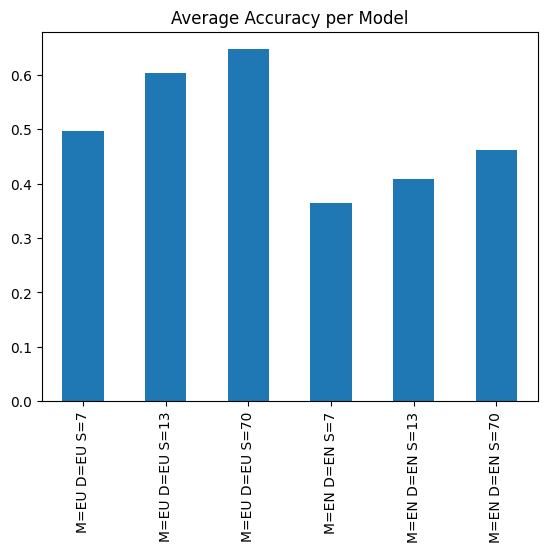

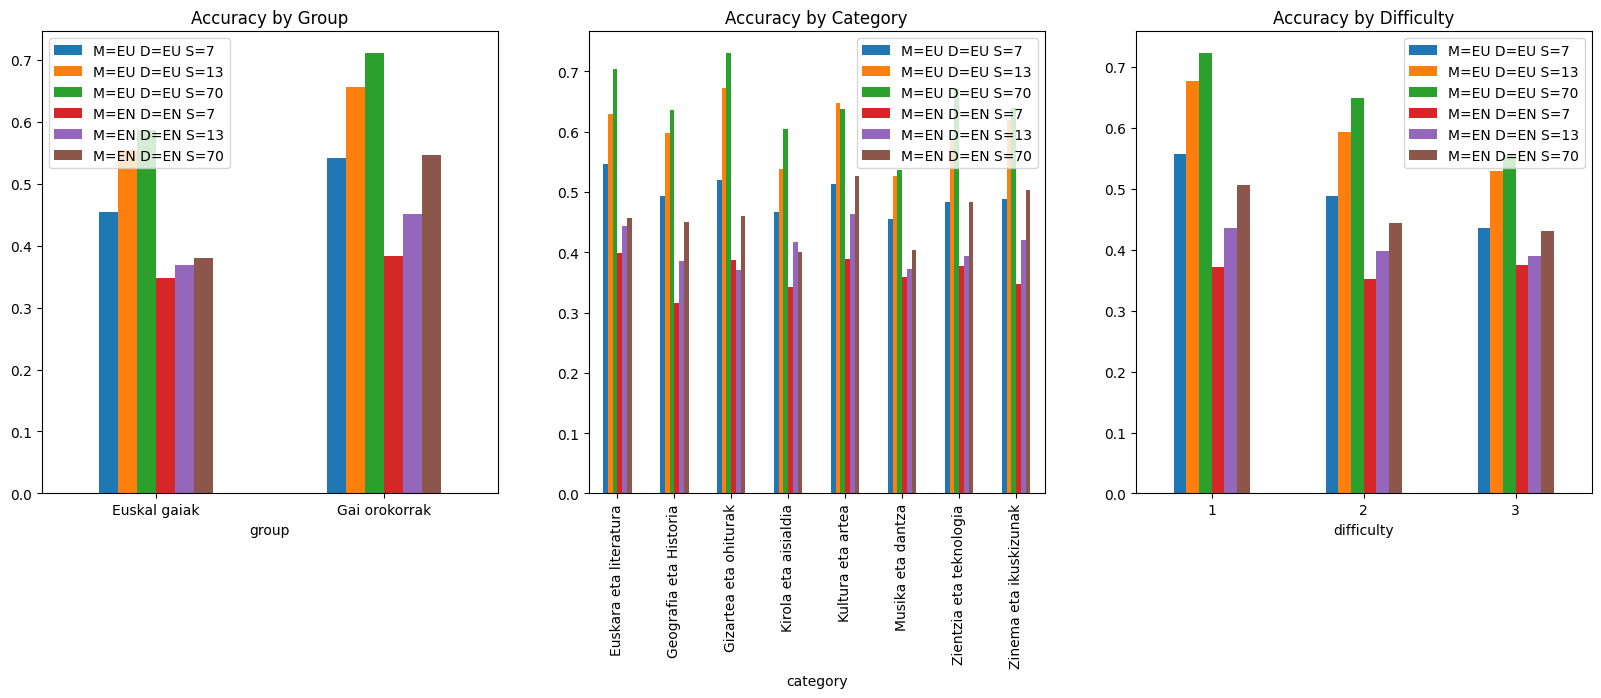

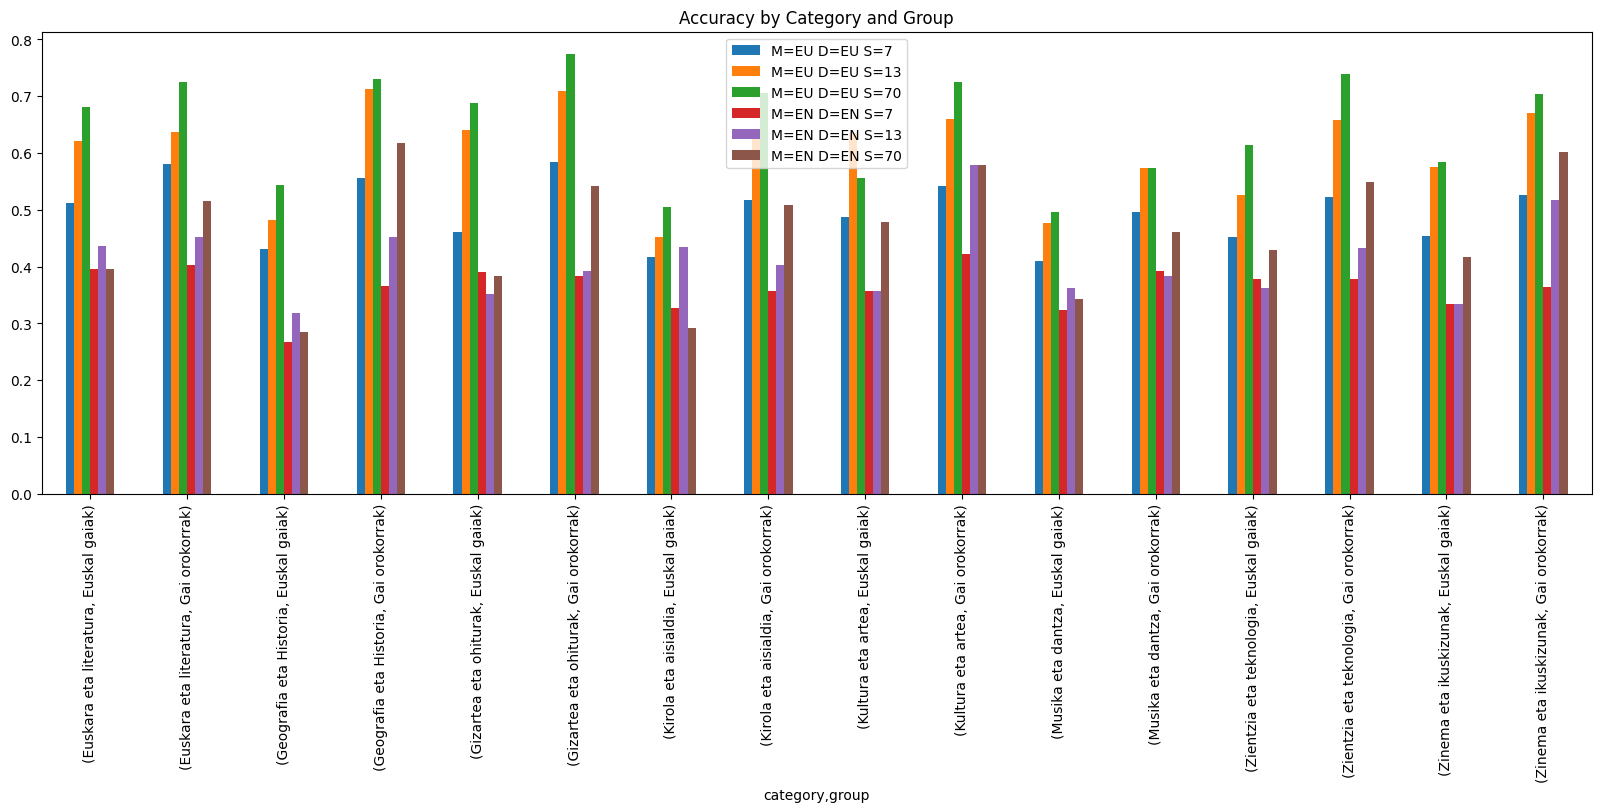

In [68]:
df_en_filtered = df_en[df_en["doc"].apply(lambda x: x["id"] in ids.values)]
df_en_13b_filtered = df_en_13b[df_en_13b["doc"].apply(lambda x: x["id"] in ids.values)]
df_en_70b_filtered = df_en_70b[df_en_70b["doc"].apply(lambda x: x["id"] in ids.values)]

plot_eus_en_sizes(df_eus_7b_filtered, df_eus_13b_filtered, df_eus_70b_filtered, df_en_filtered, df_en_13b_filtered, df_en_70b_filtered)

## Llama Eus 7B, 13B, 70B EuroHPC En Itzuli vs En Elhuyar Filtered

,M=EU D=EU S=7,M=EU D=EU S=13,M=EU D=EU S=70,M=EN D=EN S=7,M=EN D=EN S=13,M=EN D=EN S=70
0,1,1,1,1,1,1
1,0,0,0,1,1,1
2,1,1,1,0,1,1
3,1,1,1,1,1,0
5,0,0,0,0,0,1
...,...,...,...,...,...,...
1994,0,0,0,0,0,0
1995,1,0,0,0,0,0
1997,1,1,1,1,1,1
1998,0,0,1,0,0,1


M=EU D=EU S=7     47.48
M=EU D=EU S=13    57.87
M=EU D=EU S=70    61.05
M=EN D=EN S=7     50.77
M=EN D=EN S=13    61.16
M=EN D=EN S=70    65.77
dtype: float64

/tmp/ipykernel_4179521/1898386133.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped = merged.groupby("group").mean()
/tmp/ipykernel_4179521/1898386133.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_difficulty = merged.groupby("difficulty").mean()
/tmp/ipykernel_4179521/1898386133.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_grouped_category = merged.groupby("catego

group,Euskal gaiak,Gai orokorrak
M=EU D=EU S=7,40.81,54.44
M=EU D=EU S=13,49.43,66.67
M=EU D=EU S=70,52.02,70.45
M=EN D=EN S=7,44.76,57.03
M=EN D=EN S=13,53.69,68.94
M=EN D=EN S=70,56.70,75.22


category       Euskara eta literatura               Geografia eta Historia  \
group                    Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                   42.86         53.23                  36.21   
M=EU D=EU S=13                  58.82         56.45                  43.97   
M=EU D=EU S=70                  55.46         62.90                  50.86   
M=EN D=EN S=7                   53.78         58.06                  38.79   
M=EN D=EN S=13                  59.66         64.52                  54.31   
M=EN D=EN S=70                  63.87         69.35                  50.00   

category                     Gizartea eta ohiturak                \
group          Gai orokorrak          Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          52.17                 38.28         63.33   
M=EU D=EU S=13         72.17                 53.91         80.83   
M=EU D=EU S=70         72.17                 50.78         82.50   
M=EN D=EN S=7          55.65                 37.50         60.00   
M=EN D=EN S=13         77.39                 54.69         76.67   
M=EN D=EN S=70         73.91                 64.06         83.33   

category       Kirola eta aisialdia               Kultura eta artea  \
group                  Euskal gaiak Gai orokorrak      Euskal gaiak   
M=EU D=EU S=7                 39.82         58.04             39.13   
M=EU D=EU S=13                34.51         58.04             50.43   
M=EU D=EU S=70                50.44         67.86             51.30   
M=EN D=EN S=7                 41.59         61.61             47.83   
M=EN D=EN S=13                41.59         66.96             54.78   
M=EN D=EN S=70                47.79         77.68             52.17   

category                     Musika eta dantza                \
group          Gai orokorrak      Euskal gaiak Gai orokorrak   
M=EU D=EU S=7          57.80             38.10         41.74   
M=EU D=EU S=13         63.30             46.67         54.78   
M=EU D=EU S=70         70.64             46.67         60.87   
M=EN D=EN S=7          55.05             38.10         45.22   
M=EN D=EN S=13         65.14             46.67         58.26   
M=EN D=EN S=70         77.06             52.38         64.35   

category       Zientzia eta teknologia               Zinema eta ikuskizunak  \
group                     Euskal gaiak Gai orokorrak           Euskal gaiak   
M=EU D=EU S=7                    45.93         54.05                  44.70   
M=EU D=EU S=13                   57.04         73.87                  47.73   
M=EU D=EU S=70                   59.26         73.87                  50.00   
M=EN D=EN S=7                    49.63         59.46                  49.24   
M=EN D=EN S=13                   59.26         65.77                  56.06   
M=EN D=EN S=70                   59.26         78.38                  61.36   

category                      
group          Gai orokorrak  
M=EU D=EU S=7          55.08  
M=EU D=EU S=13         73.73  
M=EU D=EU S=70         72.88  
M=EN D=EN S=7          61.02  
M=EN D=EN S=13         76.27  
M=EN D=EN S=70         77.97

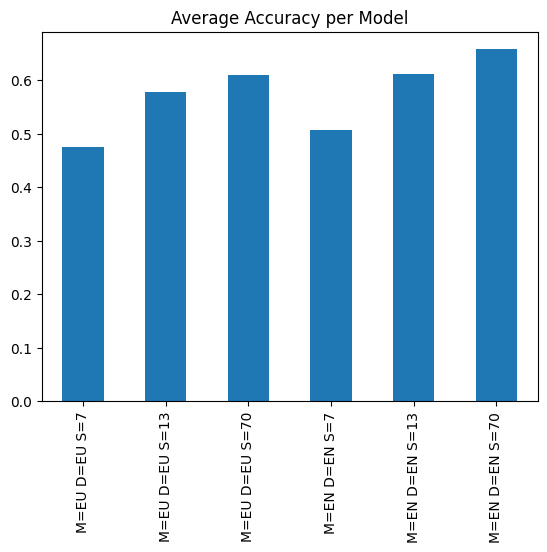

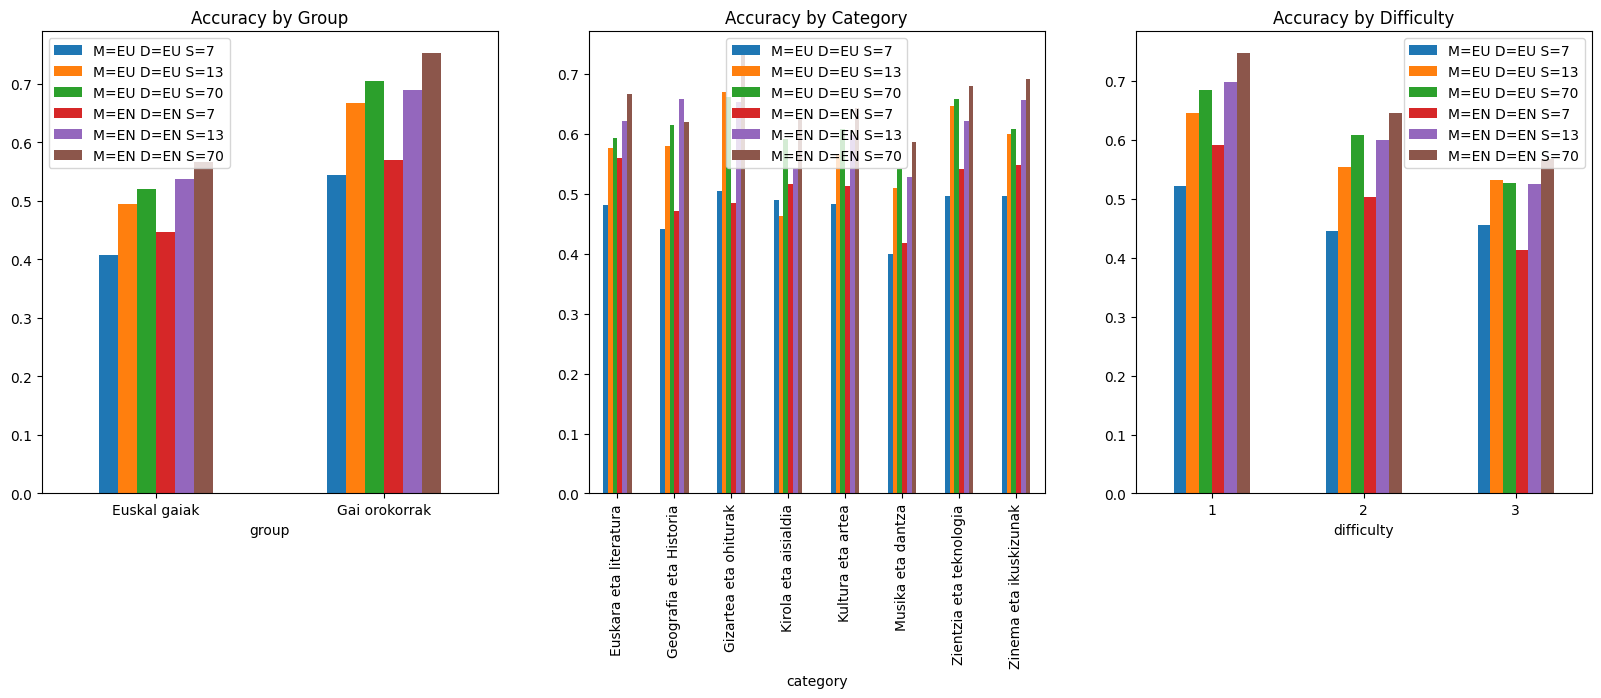

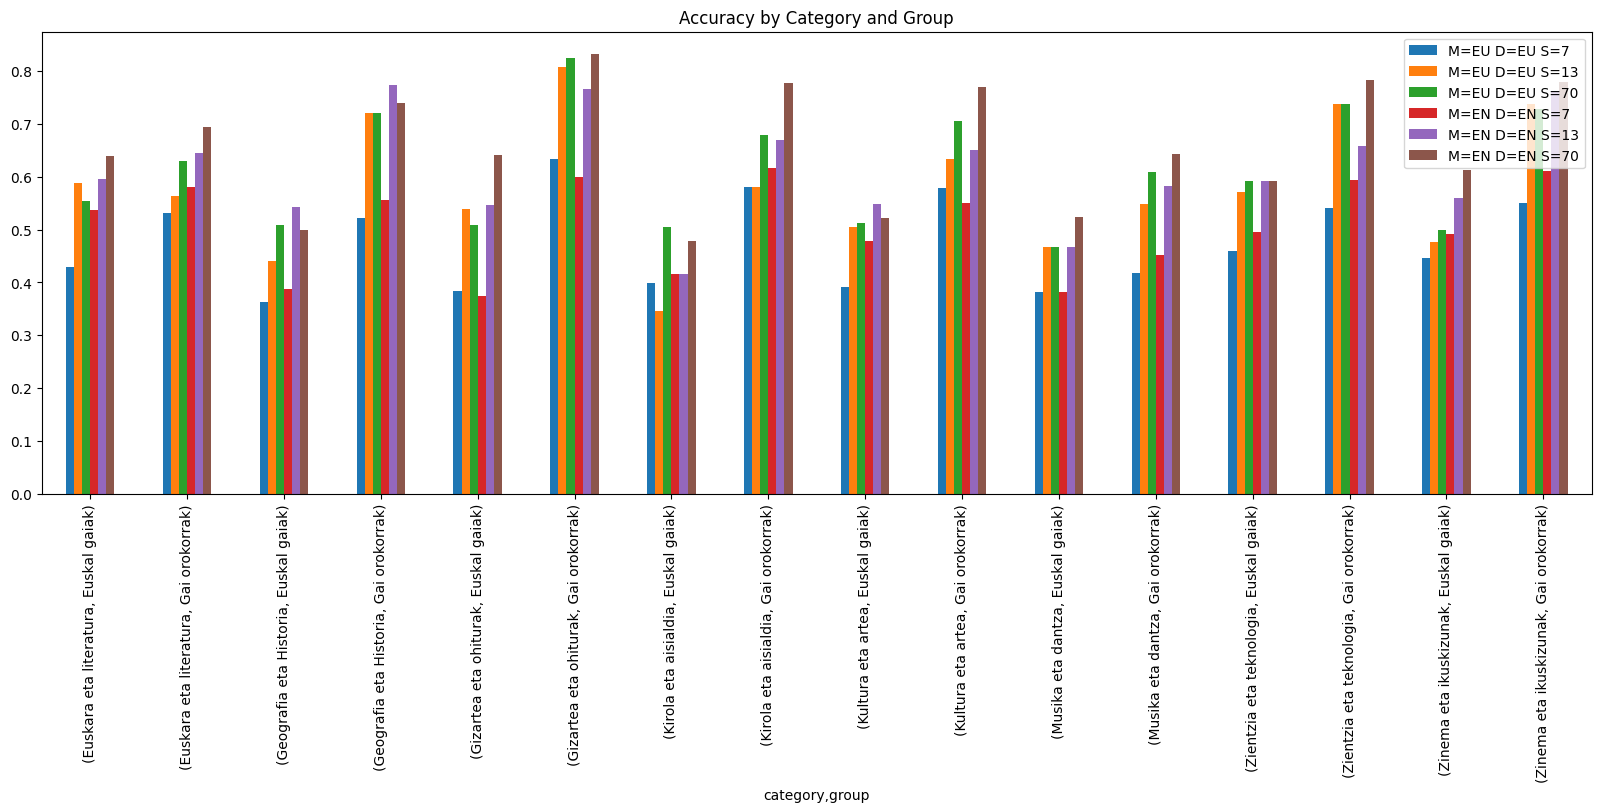

In [70]:
df_eus_mt_itzuli_7b_filtered = df_eus_mt_itzuli_7b[df_eus_mt_itzuli_7b["doc"].apply(lambda x: x["id"] in ids.values)]
df_eus_mt_itzuli_13b_filtered = df_eus_mt_itzuli_13b[df_eus_mt_itzuli_13b["doc"].apply(lambda x: x["id"] in ids.values)]
df_eus_mt_itzuli_70b_filtered = df_eus_mt_itzuli_70b[df_eus_mt_itzuli_70b["doc"].apply(lambda x: x["id"] in ids.values)]

# change elhuyar index to doc id
df_eus_mt_elhuyar_7b.index = df_eus_mt_elhuyar_7b["doc"].apply(lambda x: x["id"])
df_eus_mt_elhuyar_13b.index = df_eus_mt_elhuyar_13b["doc"].apply(lambda x: x["id"])
df_eus_mt_elhuyar_70b.index = df_eus_mt_elhuyar_70b["doc"].apply(lambda x: x["id"])

plot_eus_en_sizes(df_eus_mt_itzuli_7b_filtered, df_eus_mt_itzuli_13b_filtered, df_eus_mt_itzuli_70b_filtered, df_eus_mt_elhuyar_7b, df_eus_mt_elhuyar_13b, df_eus_mt_elhuyar_70b)